# **This file is to run code to produce various plots for the Summer 2025 SULI appointment**
#### *This file is a cleaned and organized version of the file<br>Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

#### Imports & Helpers

In [29]:
import numpy as np
np.round_ = np.round # this is to go around a metpy bug/version error
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify, math
from matplotlib.patches import Rectangle, Patch
import os
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

# — PARAMETERS — 
# Change these at the top as needed for new data:
n = 5    # number of clusters

nid = 5    # cluster ID to export dates for

# — DATA LOADING / CLEANING — 
def load_and_clean_with_time(ds_path, variables, time_dim='time'):
    ds     = xr.open_dataset(ds_path, engine='netcdf4')
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    times  = ds[time_dim].to_numpy().ravel()
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    times  = times[mask]
    df     = pd.DataFrame(data, columns=variables)
    df['time'] = pd.to_datetime(times)
    return df

# — CLUSTERING — 
def cluster_and_attach(df, variables, n_clusters):
    X      = df[variables].values
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    km     = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)
    df['cluster'] = km.labels_ + 1
    return df, km

def hourly_plot(df):
    hourly = df.groupby(['hour','cluster']).size().unstack(fill_value=0)
    hourly.plot(title='Hourly cluster frequency')
    plt.savefig('hourly.pdf')
    plt.show()

# — PLOTTING HELPERS — 
def plot_elbow(df, variables, k_max=15):
    """
    1) Standard-scale only the numeric columns you care about
    2) Run k-means for k=1..k_max-1, collect inertia
    3) Plot k vs. inertia
    """
    # --- extract & scale ---
    X = df[variables].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- elbow loop ---
    inertias = []
    K_range = range(1, k_max)
    for k in K_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
    # --- plot ---
    plt.figure()
    plt.plot(K_range, inertias, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances (inertia)')
    plt.title('Elbow Method for optimal k')
    plt.xticks(K_range)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('output3.jpg') # use this if needed
    plt.show()
def evaluate_all_cluster_scores(df, vars_list, k_range=range(2, 11)):
    dfc = df[vars_list].dropna().copy()
    X_scaled = StandardScaler().fit_transform(dfc)

    inertias = []
    silhouettes = []
    calinski_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_scaled)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
        db_scores.append(davies_bouldin_score(X_scaled, labels))

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    axs[0, 0].plot(k_range, inertias, marker='o')
    axs[0, 0].set_title("Inertia (WSS) ↓")
    axs[0, 0].grid(True)

    axs[0, 1].plot(k_range, silhouettes, marker='o')
    axs[0, 1].set_title("Silhouette Score ↑")
    axs[0, 1].grid(True)

    axs[1, 0].plot(k_range, calinski_scores, marker='o')
    axs[1, 0].set_title("Calinski–Harabasz Score ↑")
    axs[1, 0].grid(True)

    axs[1, 1].plot(k_range, db_scores, marker='o')
    axs[1, 1].set_title("Davies–Bouldin Score ↓")
    axs[1, 1].grid(True)

    for ax in axs.flat:
        ax.set_xlabel("Number of Clusters (k)")

    plt.suptitle("📊 Cluster Evaluation Metrics", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_cluster_histogram(df, n_clusters):
    counts = df['cluster'].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.xticks(range(1, n_clusters+1))
    plt.tight_layout()
    plt.savefig('output2.png')
    plt.show()

def plot_all_variable_histograms(df):
    for var in df.columns:
        if var == 'cluster': continue
        plt.figure()
        df[var].hist(bins=50, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var); plt.ylabel('Frequency')
        plt.tight_layout(); plt.show()

def plot_variable_pairs(df, n_clusters):
    sns.pairplot(df, hue='cluster',
                 hue_order=range(1, n_clusters+1),
                 palette='tab10', corner=False)
    plt.show()

def plot_box_time(df, variables, output_dir):
    df['hour'] = df.index.hour
    clusters = sorted(df['cluster'].unique())
    for var in variables:
        if var == 'cluster': continue
        data = [df.loc[df['cluster']==c, var].values for c in clusters]
        plt.figure()
        plt.boxplot(data, tick_labels=clusters, showfliers=False)
        plt.title(f'{var.capitalize()} by Cluster')
        plt.xlabel('Cluster'); plt.ylabel(var)
        plt.tight_layout()

        if output_dir:
            fname = os.path.join(output_dir, f'box_{var}.png')
            plt.savefig(fname, dpi=300)
            print(f"Saved {fname}")
        
        plt.show()

def mosaic_plot(df, cat1, cat2, title=None):
    data = df.groupby([cat1,cat2]).size().to_dict()
    plt.figure(figsize=(8,6))
    mosaic(data, title=title or f"{cat1} vs {cat2}",
           labelizer=lambda k: str(k[1]))
    plt.xlabel(cat1); plt.ylabel(cat2)
    plt.tight_layout(); plt.show()

def variable_importance_bss(df, variables, n_clusters):
    X      = df[variables].values
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    km     = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)
    c, labels = km.cluster_centers_, km.labels_
    counts = np.bincount(labels, minlength=n_clusters)
    bss = np.sum(c**2 * counts[:,None], axis=0)
    return pd.Series(bss, index=variables).sort_values(ascending=False)

def plot_per_cluster_treemaps(km, variables, n_clusters):
    # pick a colormap and grab len(variables) distinct colors
    cmap   = plt.get_cmap('tab20')
    colors = [cmap(i/len(variables)) for i in range(len(variables))]
    
    for cid in range(1, n_clusters+1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        labels = [f"{v}\n{center[i]:+.2f}" 
                  for i, v in enumerate(variables)]
        
        plt.figure(figsize=(5,5))
        squarify.plot(
            sizes=sizes,
            label=labels,
            color=colors,
            pad=True,
            bar_kwargs={'linewidth':1,'edgecolor':'white'}
        )
        plt.title(f"Cluster {cid}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def plot_all_cluster_treemaps(km, variables, n_clusters=n, cols=3):
    """
    Draws a grid of treemaps, one per cluster, using km.cluster_centers_.
    
    km          : a fitted sklearn KMeans instance
    variables   : list of variable names (in the order you trained on)
    n_clusters  : number of clusters (5 in your case)
    cols        : how many columns in the grid
    """

    cmap   = plt.get_cmap('tab20')
    colors = [cmap(i/len(variables)) for i in range(len(variables))]
    
    # layout
    rows = math.ceil(n_clusters / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    
    for cid in range(1, n_clusters+1):
        ax = axes[cid-1]
        
        # get the standardized center for this cluster
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        labels = [f"{v}\n{center[i]:+.2f}" for i, v in enumerate(variables)]
        
        # normalize to 100%
        sizes = sizes / sizes.sum() * 100
        
        squarify.plot(
            sizes=sizes,
            label=labels,
            color=colors,
            ax=ax,
            alpha=0.8,
            pad=True
        )
        ax.set_title(f"Cluster {cid}")
        ax.axis('off')
    
    # any leftover subplots get turned off
    for ax in axes[n_clusters:]:
        ax.axis('off')
    
    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.savefig('D://Figures//crocus_2023_NEIU_treemaps.png')
    plt.show()

def export_cluster_dates(df, cluster_id, filename):
    dates = df.index[df['cluster']==cluster_id]
    with open(filename, 'w') as f:
        for dt in dates:
            f.write(dt.strftime('%Y-%m-%d %H:%M:%S')+"\n")
    print(f"Saved {len(dates)} timestamps to {filename}")

def plot_cluster_timeline(df, n_clusters):
    fig, ax = plt.subplots(figsize=(12,2))

    # 1) grab the 'viridis' colormap with exactly n_clusters discrete colors
    cmap = plt.get_cmap('viridis', n_clusters)

    # 2) create a norm so cluster=1→bin0, …, cluster=n→bin(n−1)
    bounds = np.arange(1, n_clusters+2)
    norm   = BoundaryNorm(bounds, cmap.N)

    sc = ax.scatter(
        df.index,
        df['cluster'],
        c=df['cluster'],
        cmap=cmap,
        norm=norm,
        s=6,
        marker='|'
    )

    ax.set_yticks(np.arange(1, n_clusters+1))
    ax.set_ylabel('Cluster')
    ax.set_xlabel('Time')
    ax.set_title('Cluster assignment over time')

    # 3) colorbar with discrete ticks
    cbar = plt.colorbar(
        sc, ax=ax,
        ticks=np.arange(1, n_clusters+1),
        spacing='proportional',
        orientation='horizontal',
        pad=0.3
    )
    cbar.set_label('Cluster')
    plt.tight_layout()
    plt.savefig('D://Figures//cluster_timeline.png', dpi = 350, bbox_inches='tight')
    plt.show()

def cluster_through_time(df):
    # 1) Compute the hourly means for each cluster
    df['hour'] = df.index.hour
    hourly = df.groupby(['hour','cluster'])['pm2.5'].mean().unstack(fill_value=np.nan)
    
    # 2) Set up a grid of subplots
    n_clusters = hourly.shape[1]
    cols       = 3                    # how many panels per row
    rows       = math.ceil(n_clusters/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=False, sharey=False)
    axes = axes.flatten()
    
    # 3) Plot one line per cluster on its own axis
    for idx, cid in enumerate(hourly.columns, start=0):
        ax = axes[idx]
        ax.plot(hourly.index, hourly[cid], marker=' ', linewidth=2)
        ax.set_title(f"Cluster {cid}")
        ax.set_xticks(range(0,24,4))
        if idx % cols == 0:
            ax.set_ylabel("Mean PM$_{2.5}$ (µg/m³)")
        ax.set_xlabel("Hour of Day")
    
    # 4) Turn off any unused subplots
    for ax in axes[n_clusters:]:
        ax.axis('off')
    
    # 5) Overall title and layout
    fig.suptitle("Average Diurnal PM$_{2.5}$ by Cluster", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.savefig('D://Figures//ave_diurnal_pm25_by_cluster.png', dpi = 350, bbox_inches='tight')
    plt.show()

# def plot_all_boxplots_by_cluster(df, variables, n_clusters, n_cols=4, figsize=(6, 12), output_path=None):
#     """
#     Draws one boxplot per variable showing its distribution across clusters,
#     all packed into a narrow figure of n_cols columns.

#     Parameters
#     ----------
#     df         : pd.DataFrame with a 'cluster' column and datetime index
#     variables  : list of variable names to plot
#     n_clusters : how many clusters (1..n_clusters)
#     n_cols     : how many columns in the grid (default 2 for narrow figure)
#     figsize    : overall figure size (width, height)
#     output_path: if given, saves to this file via fig.savefig(...)
#     """
#     n_vars = len(variables)
#     n_rows = math.ceil(n_vars / n_cols)

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
#     axes = axes.flatten()

#     for i, var in enumerate(variables):
#         ax = axes[i]
#         # collect one array per cluster
#         data = [df.loc[df['cluster'] == c, var].dropna().values
#                 for c in range(1, n_clusters+1)]

#         bp = ax.boxplot(
#             data,
#             tick_labels=list(range(1, n_clusters+1)),
#             showfliers=False,
#             widths=0.6
#         )
#         ax.set_title(var, fontsize=10)
#         # only bottom‐row subplots get x‐labels
#         if i // n_cols == n_rows - 1:
#             ax.set_xlabel("Cluster")
#         else:
#             ax.set_xticklabels([])

#         # only first‐column subplots get y‐labels
#         # if i % n_cols == 0:
#         #     ax.set_ylabel(var)
#         # else:
#         #     ax.set_yticklabels([])

#     # turn off any extra axes
#     for j in range(n_vars, len(axes)):
#         axes[j].axis('off')

#     fig.suptitle("Boxplots of Each Variable by Cluster", fontsize=14, y=1.02)
#     fig.tight_layout()
#     if output_path:
#         fig.savefig(output_path, bbox_inches='tight', dpi=300)
#         print(f"Saved boxplot grid to {output_path!r}")
#     plt.show()

# def plot_all_boxplots_by_cluster(
#     df,
#     variables,
#     n_clusters,
#     display_names=None,
#     nonneg_vars=None,
#     n_cols=4,
#     figsize=(6, 12),
#     output_path=None
# ):
#     """
#     Draws one boxplot per variable showing its distribution across clusters,
#     all packed into a narrow figure of n_cols columns.

#     Parameters
#     ----------
#     df            : pd.DataFrame with a 'cluster' column and datetime index
#     variables     : list of variable names to plot
#     n_clusters    : how many clusters (1..n_clusters)
#     display_names : dict mapping variable → display title
#     nonneg_vars   : set of vars whose negative values should be dropped
#     n_cols        : how many columns in the grid
#     figsize       : overall figure size (width, height)
#     output_path   : if given, saves to this file via fig.savefig(...)
#     """
#     # default drop‐below‐zero for particulate & gas vars
#     if nonneg_vars is None:
#         nonneg_vars = {'pm2.5','pm1.0','pm10.0','co','no','o3','no2'}

#     # default to identity display names
#     if display_names is None:
#         display_names = {v: v for v in variables}

#     n_vars = len(variables)
#     n_rows = math.ceil(n_vars / n_cols)

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
#     axes = axes.flatten()

#     for i, var in enumerate(variables):
#         ax = axes[i]

#         # collect one array per cluster, dropping negatives if requested
#         data = []
#         for c in range(1, n_clusters+1):
#             vals = df.loc[df['cluster'] == c, var].dropna().values
#             if var in nonneg_vars:
#                 vals = vals[vals >= 0]
#             data.append(vals)

#         ax.boxplot(
#             data,
#             tick_labels=list(range(1, n_clusters+1)),
#             showfliers=False,
#             widths=0.6
#         )
#         # use mapped display name here:
#         ax.set_title(display_names.get(var, var), fontsize=10)

#         # only bottom‐row subplots get x‐labels
#         if i // n_cols == n_rows - 1:
#             ax.set_xlabel("Cluster")
#         else:
#             ax.set_xticklabels([])

#     # turn off any extra axes
#     for j in range(n_vars, len(axes)):
#         axes[j].axis('off')

#     fig.suptitle("Boxplots of Each Variable by Cluster", fontsize=14, y=1.02)
#     fig.tight_layout()

#     if output_path:
#         fig.savefig(output_path, bbox_inches='tight', dpi=300)
#         print(f"Saved boxplot grid to {output_path!r}")

#     plt.show()


def plot_all_boxplots_by_cluster(
    df,
    variables,
    n_clusters,
    cluster_colors,
    cluster_names,
    display_names=None,
    nonneg_vars=None,
    n_cols=4,
    figsize=(6,12),
    output_path=None
):
    """
    Draws one boxplot per variable showing its distribution across clusters,
    colored by cluster, all packed into a grid of n_cols columns.

    Parameters
    ----------
    df            : pd.DataFrame with a 'cluster' column and datetime index
    variables     : list of variable names to plot
    n_clusters    : how many clusters (1..n_clusters)
    cluster_colors: dict mapping cluster_id → matplotlib color
    cluster_names : dict mapping cluster_id → display name (for legend)
    display_names : dict mapping variable → display title
    nonneg_vars   : set of vars whose negative values should be dropped
    n_cols        : how many columns in the grid
    figsize       : overall figure size (width, height)
    output_path   : if given, saves to this file via fig.savefig(...)
    """
    # default drop‐below‐zero for particulates & gases
    if nonneg_vars is None:
        nonneg_vars = {'pm2.5','pm1.0','pm10.0','co','no','o3','no2'}

    # default to identity display names
    if display_names is None:
        display_names = {v:v for v in variables}

    n_vars = len(variables)
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=figsize,
                             sharex=True)
    axes = axes.flatten()

    for i, var in enumerate(variables):
        ax = axes[i]

        # gather data per cluster, dropping negatives if requested
        data = []
        for cid in range(1, n_clusters+1):
            vals = df.loc[df['cluster']==cid, var].dropna().values
            if var in nonneg_vars:
                vals = vals[vals>=0]
            data.append(vals)

        # draw boxplot with patch_artist so we can color them
        bp = ax.boxplot(
            data,
            tick_labels=list(range(1, n_clusters+1)),
            showfliers=False,
            widths=0.6,
            patch_artist=True
        )

        # color each box according to cluster_colors
        for cid, box in enumerate(bp['boxes'], start=1):
            box.set_facecolor(cluster_colors[cid])
            box.set_edgecolor('black')

        # optional: color medians, whiskers, caps, etc.
        for whisker in bp['whiskers']:
            whisker.set_color('black')
        for cap in bp['caps']:
            cap.set_color('black')
        for median in bp['medians']:
            median.set_color('yellow')
            median.set_linewidth(1.5)

        # set prettier title
        ax.set_title(display_names.get(var, var), fontsize=10)

        # only bottom‐row subplots get x‐labels
        if i // n_cols == n_rows - 1:
            ax.set_xlabel("Cluster")
        else:
            ax.set_xticklabels([])

    # turn off any extra axes
    for j in range(n_vars, len(axes)):
        axes[j].axis('off')

    fig.suptitle("Boxplots of Each Variable by Cluster", fontsize=16, y=1.02)
    fig.tight_layout()

    # add a shared legend for clusters
    legend_handles = [
        Patch(facecolor=cluster_colors[cid],
              edgecolor='black',
              label=cluster_names[cid])
        for cid in sorted(cluster_names)
    ]
    fig.legend(
        handles=legend_handles,
        title="Cluster",
        loc='lower right',
        ncol=1,
        bbox_to_anchor=(1.0, 0.25),
        frameon=False,
        fontsize='medium'
    )
    if output_path:
        fig.savefig(output_path, bbox_inches='tight', dpi=450)
        print(f"Saved boxplot grid to {output_path!r}")
    plt.show()

    
def multifig(df):
    # 1) cluster → name mapping
    cluster_names = {
        1: 'Smog (1)',
        2: 'Daytime (2)',
        3: 'Background (3)',
        4: 'Smoke (4)',
        5: 'Nocturnal (5)',
    }
    # 2) consistent palette
    palette = sns.color_palette("tab10", len(cluster_names))
    cluster_colors = {cid: palette[i] for i, cid in enumerate(cluster_names)}

    # 3a) size counts
    counts = df['cluster'].value_counts().sort_index()
    counts.index = [cluster_names[i] for i in counts.index]

    # 3b) hourly frequency
    hourly = df.groupby(['hour','cluster']).size().unstack(fill_value=0)
    hourly.columns = [cluster_names[c] for c in hourly.columns]

    # 4) build figure
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs  = fig.add_gridspec(2, 2)

    # 4a) size bar
    ax1 = fig.add_subplot(gs[0,0])
    bar_colors = [cluster_colors[cid] for cid in sorted(cluster_names)]
    ax1.bar(counts.index, counts.values, color=bar_colors)
    ax1.set_title("Cluster Size Distribution", fontsize=14, pad=6)
    ax1.set_ylabel("Count")
    ax1.set_xticklabels(counts.index, rotation=30, ha='right')

    # 4b) hourly line
    ax2 = fig.add_subplot(gs[0,1])
    for cid in sorted(cluster_names):
        name = cluster_names[cid]
        ax2.plot(hourly.index, hourly[name],
                 label=name,
                 color=cluster_colors[cid],
                 lw=2)
    ax2.set_title("Hourly Cluster Frequency", fontsize=14, pad=6)
    ax2.set_xlabel("Hour of Day (UTC)")
    ax2.set_ylabel("Frequency")

    # 4c) timeline scatter
    ax3 = fig.add_subplot(gs[1,:])
    for cid in sorted(cluster_names):
        mask = df['cluster']==cid
        ax3.scatter(df.index[mask],
                    [cid]*mask.sum(),
                    color=cluster_colors[cid],
                    marker='s',
                    s=20,
                    zorder=2)
    ax3.set_yticks(list(cluster_names))
    ax3.set_yticklabels([cluster_names[c] for c in cluster_names])
    ax3.set_title("Cluster Assignment Over Time", fontsize=14, pad=6)
    ax3.set_xlabel("Date")

    # --- now add all of your July 4 / shading / outlines on ax3 ---

    # a) July 4th vertical line + label
    j4 = pd.Timestamp("2023-07-04")
    ax3.axvline(j4, color='black', ls='--', lw=1.5, zorder=1)
    ax3.text(j4, ax3.get_ylim()[1]*0.95-1.5, "July 4",
             rotation=0, va="top", ha="right",
             backgroundcolor="white", zorder=3)

    # b) broad shaded intervals
    shaded = [
        ("2023-05-20","2023-05-25"),
        ("2023-06-01","2023-06-10"),
        ("2023-06-15","2023-06-18"),
        ("2023-06-20","2023-06-29"),
        ("2023-07-02","2023-07-06"),
        ("2023-07-09","2023-07-12"),
        ("2023-07-16","2023-07-19"),
        ("2023-07-21","2023-08-02"),
        ("2023-08-03","2023-08-03"),
        ("2023-08-04","2023-08-05"),
        ("2023-08-09","2023-08-10"),
        ("2023-08-11","2023-08-13"),
        ("2023-08-16","2023-08-31"),
    ]
    for start,end in shaded:
        ax3.axvspan(pd.to_datetime(start),
                    pd.to_datetime(end),
                    color="lightgray",
                    alpha=0.3,
                    zorder=0)

    # c) special red‐outlined sub‐ranges
    outlines = [
        ("2023-06-05","2023-06-06"),
        ("2023-06-16","2023-06-18"),
        ("2023-06-28","2023-06-29"),
        ("2023-07-16","2023-07-17"),
        ("2023-07-24","2023-07-25"),
        ("2023-08-01","2023-08-01"),
        ("2023-08-23","2023-08-23"),
    ]
    for start,end in outlines:
        ax3.axvspan(pd.to_datetime(start),
                    pd.to_datetime(end),
                    fill=True,
                    color='red',
                    edgecolor="red",
                    linewidth=1.5,
                    zorder=1,
                    alpha=0.3)

    # 5) first legend: clusters
    legend_elems = [
        Line2D([0],[0], color=cluster_colors[cid], lw=3, label=cluster_names[cid])
        for cid in sorted(cluster_names)
    ]
    fig.legend(
        title="Clusters",
        handles=legend_elems,
        loc="lower center",
        ncol=len(cluster_names),
        frameon=True,
        bbox_to_anchor=(0.5, -0.05)
    )

    # 6) second legend: smoke shading
    smoke_handles = [
        # Patch(facecolor="cyan", label="July 4th"),
        Patch(facecolor="lightgray", alpha=0.3,   label="Wildfire Smoke"),
        Patch(facecolor="none",   edgecolor="red", color='red', linewidth=1.5, alpha = 0.3, label="Intense Wildfire Smoke"),
    ]
    fig.legend(
        handles=smoke_handles,
        loc="lower center",
        ncol=3,
        frameon=True,
        bbox_to_anchor=(0.5, -0.1)
    )

    # 7) title, save, show...
    fig.suptitle("Overview of Cluster Statistics", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig("D://Figures//all_clusters_summary.png", bbox_inches="tight", dpi=450)
    plt.show()

    
# def new_plot_all_cluster_treemaps(
#     km, variables, cluster_labels,
#     n_clusters=5, cols=3,
#     small_area_threshold=150.0,
#     arrow_x_offset=2.5,
#     arrow_y_offset=0,        # <— new parameter
# ):
#     """
#     km              : fitted KMeans model
#     variables       : list of feature names
#     cluster_labels  : dict mapping cluster_id → display name
#     small_area_threshold : area below which labels get pulled out
#     arrow_x_offset  : how far to the right to place the small‐label column
#     """
#      # 1) Make a display‐name map so u_wind→U, v_wind→V, else unchanged
#     display = {v: v for v in variables}
#     display.update({
#         **{v: v for v in variables},
#         'pm2.5': 'PM₂.₅',
#         'pm1.0': 'PM₁.₀',
#         'pm10.0':'PM₁₀',
#         'co':      'CO',
#         'no':      'NO',
#         'o3':      'O₃',
#         'no2':     'NO₂',
#         'temperature':'T',
#         'dewpoint':'Td',
#         'u_wind': 'U',
#         'v_wind': 'V',
#     })
#     # 1) Prepare colors & force one squarify layout so patch order is consistent
#     cmap    = plt.get_cmap('tab20')
#     palette = [cmap(i/len(variables)) for i in range(len(variables))]
#     var_colors = dict(zip(variables, palette))
#     _ = squarify.squarify([1]*len(variables), 0,0,100,100)

#     # 2) Set up figure/grid
#     rows = int(np.ceil(n_clusters/cols))
#     fig, axes = plt.subplots(rows, cols,
#                              figsize=(cols*3.5, rows*3.5),
#                              constrained_layout=True)
#     axes = axes.flatten()

#     # 3) Draw each cluster treemap & center‐place *all* labels
#     #    We'll also collect the tiny Cluster-4 Text objects for later adjustment.
#     texts4 = []
#     for cid, ax in enumerate(axes[:n_clusters], start=1):
#         center = km.cluster_centers_[cid-1]
#         sizes  = np.abs(center)
#         sizes  = sizes/sizes.sum()*100

#         squarify.plot(sizes=sizes,
#                       label=None,
#                       color=[var_colors[v] for v in variables],
#                       ax=ax, pad=True)
#         ax.set_title(cluster_labels[cid], fontsize=14, pad=6)
#         ax.axis('off')

#         # place every text at the exact center
#         for patch, var in zip(ax.patches, variables):
#             val = center[variables.index(var)]
#             txt = f"{val:+.2f}"
#             cx  = patch.get_x() + patch.get_width()/2
#             cy  = patch.get_y() + patch.get_height()/2

#             t = ax.text(cx, cy, txt,
#                         ha='center', va='center',
#                         fontsize=8, weight='bold',
#                         color='black')
#             if cid == 4:
#                 # only care about the small ones; we'll filter by area below
#                 texts4.append((patch, t))
#     # 4) pull out Cluster-4 labels and stack them
#     ax4   = axes[3]
#     xlim  = ax4.get_xlim()
#     ylim  = ax4.get_ylim()
#     x_text = xlim[1] + arrow_x_offset

#     # filter & sort by patch center-y
#     small_labels = sorted(
#         [(p, t) for (p,t) in texts4
#          if p.get_width()*p.get_height() < small_area_threshold],
#         key=lambda pt: pt[0].get_y() + pt[0].get_height()/2,
#         reverse=True
#     )

#     n = len(small_labels)
#     if n:
#         # shrink the endpoints a bit to avoid clipping
#         y_min, y_max = ylim
#         y_margin = (y_max - y_min)*0.05
#         y_positions = np.linspace(
#             y_max - y_margin + arrow_y_offset -2.5,
#             y_min + y_margin   + arrow_y_offset +50,
#             n
#         )

#         for (patch, text), y_text in zip(small_labels, y_positions):
#             cx = patch.get_x() + patch.get_width()/2
#             cy = patch.get_y() + patch.get_height()/2
#             val= text.get_text()

#             ax4.annotate(
#                 val,
#                 xy=(cx-1, cy),
#                 xytext=(x_text, y_text),
#                 arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
#                 ha='left', va='center',
#                 fontsize=8, weight='bold'
#             )
#             text.set_visible(False)

#     # 5) Turn off any leftover axes
#     for ax in axes[n_clusters:]:
#         ax.axis('off')

#     # 6) shared legend
#     handles = [
#         Patch(color=var_colors[v], label=display[v])
#         for v in variables
#     ]
#     fig.legend(
#         handles=handles,
#         ncol=4,
#         loc='lower left',
#         bbox_to_anchor=(0.69, 0.35),
#         frameon=False,
#         fontsize=9
#     )

#     fig.suptitle("Per-Cluster Variable Treemaps", fontsize=18, y=1.02)
#     plt.tight_layout()
#     plt.savefig("D://Figures//all_clusters_treemaps_summary.png", bbox_inches='tight', dpi=450)
#     plt.show()

def new_plot_all_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=5, cols=3,
    small_area_threshold=150.0,
    arrow_x_offset=2.5,
    arrow_y_offset=0.0,
):
    # a) display‐name map
    display = {v:v for v in variables}
    display.update({
        'pm2.5': 'PM₂.₅',
        'pm1.0': 'PM₁.₀',
        'pm10.0':'PM₁₀',
        'co':      'CO',
        'no':      'NO',
        'o3':      'O₃',
        'no2':     'NO₂',
        'temperature':'T',
        'dewpoint':'Td',
        'u_wind': 'U',
        'v_wind': 'V',
    })

    # b) colors + one dummy squarify pass
    cmap    = plt.get_cmap('tab20')
    palette = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = dict(zip(variables, palette))
    _ = squarify.squarify([1]*len(variables), 0,0,100,100)

    # c) set up grid
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # we'll collect (patch, txt_handle) for cluster‑4 small boxes
    texts4 = []

    # d) draw treemaps + center labels
    for cid, ax in enumerate(axes[:n_clusters], start=1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes/sizes.sum()*100

        squarify.plot(
            sizes=sizes,
            label=None,
            color=[var_colors[v] for v in variables],
            ax=ax, pad=True
        )
        ax.set_title(cluster_labels[cid], fontsize=14, pad=6)
        ax.axis('off')

        # now place center text on each patch
        for patch, var in zip(ax.patches, variables):
            val = center[variables.index(var)]
            label = display[var]
            num   = f"{val:+.2f}"
            cx    = patch.get_x() + patch.get_width()/2
            cy    = patch.get_y() + patch.get_height()/2
            area  = patch.get_width()*patch.get_height()

            if cid==4 and area < small_area_threshold:
                # small cluster‑4: draw only the number for now,
                # record to pull out later
                t = ax.text(
                    cx, cy, num,
                    ha='center', va='center',
                    fontsize=8, weight='bold', color='black'
                )
                texts4.append((patch, num, t))
            else:
                # everyone else: draw name + number
                ax.text(
                    cx, cy,
                    f"{label}\n{num}",
                    ha='center', va='center',
                    fontsize=8, weight='bold', color='black'
                )

    # e) pull‑out of small cluster‑4 labels
    ax4    = axes[3]   # zero‑based: cluster 4 is at index 3
    xlim   = ax4.get_xlim()
    ylim   = ax4.get_ylim()
    x_text = xlim[1] + arrow_x_offset

    # keep only the small ones, sort by their y so we stack top→bottom
    small4 = sorted(
        [ (p, num, t) for p,num,t in texts4 ],
        key=lambda x: x[0].get_y()+x[0].get_height()/2,
        reverse=True
    )

    n = len(small4)
    if n>0:
        # evenly spaced Y positions inside the axis
        y_min, y_max = ylim
        margin = (y_max-y_min)*0.05
        y_positions = np.linspace(
            y_max - margin + arrow_y_offset -2.5,
            y_min + margin + arrow_y_offset +50,
            n
        )
        for (patch, num, old_text), y_t in zip(small4, y_positions):
            cx = patch.get_x() + patch.get_width()/2
            cy = patch.get_y() + patch.get_height()/2

            # draw arrow+number
            ax4.annotate(
                num,
                xy=(cx, cy),
                xytext=(x_text, y_t),
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
                ha='left', va='center',
                fontsize=8, weight='bold', color='black'
            )
            # hide the original small number
            old_text.set_visible(False)

    # f) disable any extra axes
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # g) legend of variables, using the display codes
    handles = [
        Patch(color=var_colors[v], label=display[v])
        for v in variables
    ]
    fig.legend(
        handles=handles, ncol=4,
        loc='lower left',
        bbox_to_anchor=(0.69, 0.35),
        frameon=False, fontsize=9
    )

    fig.suptitle("Per‑Cluster Variable Treemaps", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig("D://Figures//all_clusters_treemaps_summary.png", bbox_inches='tight', dpi=450)
    plt.show()


# def new_plot_all_cluster_treemaps(km, variables, cluster_annotations, n_clusters=n, cols=3):
#     """
#     Draws a cols×rows grid of treemaps—one treemap per cluster—
#     with consistent colors, only numeric labels in-tile,
#     and a shared legend below.
#     """
#     # 1) Make a display‐name map so u_wind→U, v_wind→V, else unchanged
#     display = {v: v for v in variables}
#     display.update({
#         **{v: v for v in variables},
#         'pm2.5': 'PM₂.₅',
#         'pm1.0': 'PM₁.₀',
#         'pm10.0':'PM₁₀',
#         'co':      'CO',
#         'no':      'NO',
#         'o3':      'O₃',
#         'no2':     'NO₂',
#         'temperature':'T',
#         'dewpoint':'Td',
#         'u_wind': 'U',
#         'v_wind': 'V',
#     })

#     # 2) one color per variable
#     cmap      = plt.get_cmap('tab20')
#     var_colors= {v: cmap(i/len(variables)) for i,v in enumerate(variables)}

#     # 3) prepare the tile layout (unit squares)
#     unit_sizes = np.ones(len(variables))
#     base_rects = squarify.squarify(unit_sizes, 0, 0, 100, 100)  # fixed positions

#     # 4) set up a rows×cols grid
#     rows = math.ceil(n_clusters/cols)
#     fig, axes = plt.subplots(
#         rows, cols, 
#         figsize=(cols*3.5, rows*3.5), 
#         constrained_layout=True
#     )
#     axes = axes.flatten()

#     # 5) draw each cluster’s treemap
#     for cid in range(1, n_clusters+1):
#         ax     = axes[cid-1]
#         center = km.cluster_centers_[cid-1]
#         sizes  = np.abs(center)
#         sizes  = sizes / sizes.sum() * 100           # normalize to 100

#         # labels = just the "+0.XX" strings
#         labels = [cluster_annotations[cid][v] for v in variables]

#         # colors in the same order as variables
#         colors = [var_colors[v] for v in variables]

#         # single call (no inner Python loop)
#         squarify.plot(
#             sizes=sizes,
#             label=labels,
#             color=colors,
#             ax=ax,
#             pad=True,
#             text_kwargs={'fontsize':10, 'weight':'bold'}
#         )
#         ax.set_title(f"Cluster {cid}", fontsize=10, pad=6)
#         ax.axis('off')

#     # turn off any extra axes
#     for ax in axes[n_clusters:]:
#         ax.axis('off')

#     # 6) shared legend
#     handles = [
#         Patch(color=var_colors[v], label=display[v])
#         for v in variables
#     ]
#     fig.legend(
#         handles=handles,
#         ncol=4,
#         loc='lower left',
#         bbox_to_anchor=(0.67, 0.4),
#         frameon=False,
#         fontsize=9
#     )

#     fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
#     plt.show()


#### Load & Clean

In [7]:
vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2','temperature','dewpoint','u_wind','v_wind']
variables = vars_list

df = load_and_clean_with_time('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)

#### Cluster & Attach

In [8]:
df, km = cluster_and_attach(df, vars_list, n_clusters=n)

# Make 'time' the index and extract hour
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['hour'] = df.index.hour

print(df.head())
print(df['cluster'].value_counts().sort_index())
print(df.head(-1))

                         pm2.5      pm1.0     pm10.0        co        no  \
time                                                                       
2023-05-20 00:00:00  28.350000  24.050000  35.450000  0.218233  0.012033   
2023-05-20 00:30:00  22.733333  19.316667  28.150000  0.179633  0.012567   
2023-05-20 01:00:00  23.266667  19.966667  28.416667  0.173333  0.013800   
2023-05-20 01:30:00  20.916667  17.783333  25.566667  0.179433  0.016300   
2023-05-20 02:00:00  19.633333  16.633333  23.583333  0.185333  0.017000   

                           o3       no2  temperature  dewpoint    u_wind  \
time                                                                       
2023-05-20 00:00:00  0.027467  0.013567    15.220000  7.995897 -1.607238   
2023-05-20 00:30:00  0.022667  0.009133    14.220000  6.396147 -1.808306   
2023-05-20 01:00:00  0.020900  0.010767    13.826667  6.456700 -2.156636   
2023-05-20 01:30:00  0.022067  0.010200    13.553333  6.554624 -1.531059   
2023-05-20 

#### Timezone check

In [3]:
# time_check = xr.open_dataset('D://Data//crocus_neiu_a1_and_filtered_30min.nc', engine = 'netcdf4')
# time_check
ds = xr.open_dataset("D://Data//aqt//crocus_neiu_aqt_a1_20230520_000000.nc", decode_times=True)
print(ds.time.attrs)
print(ds.time.encoding)

{}
{'dtype': dtype('int64'), 'zlib': False, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': False, 'complevel': 0, 'fletcher32': False, 'contiguous': True, 'chunksizes': None, 'source': 'D:\\Data\\aqt\\crocus_neiu_aqt_a1_20230520_000000.nc', 'original_shape': (1440,), 'units': 'nanoseconds since 2023-05-20 00:00:56.745387258', 'calendar': 'proleptic_gregorian'}


#### Hourly Clusters

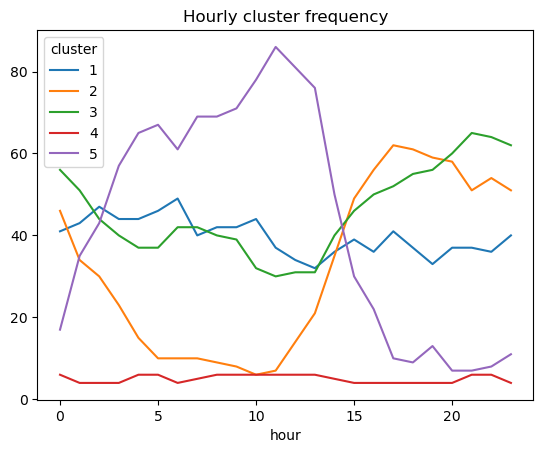

In [6]:
hourly_plot(df)

#### Cluster Testing

C:\Users\video\AppData\Local\Temp\ipykernel_22320\2740669601.py:119: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\video\.conda\envs\my_project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


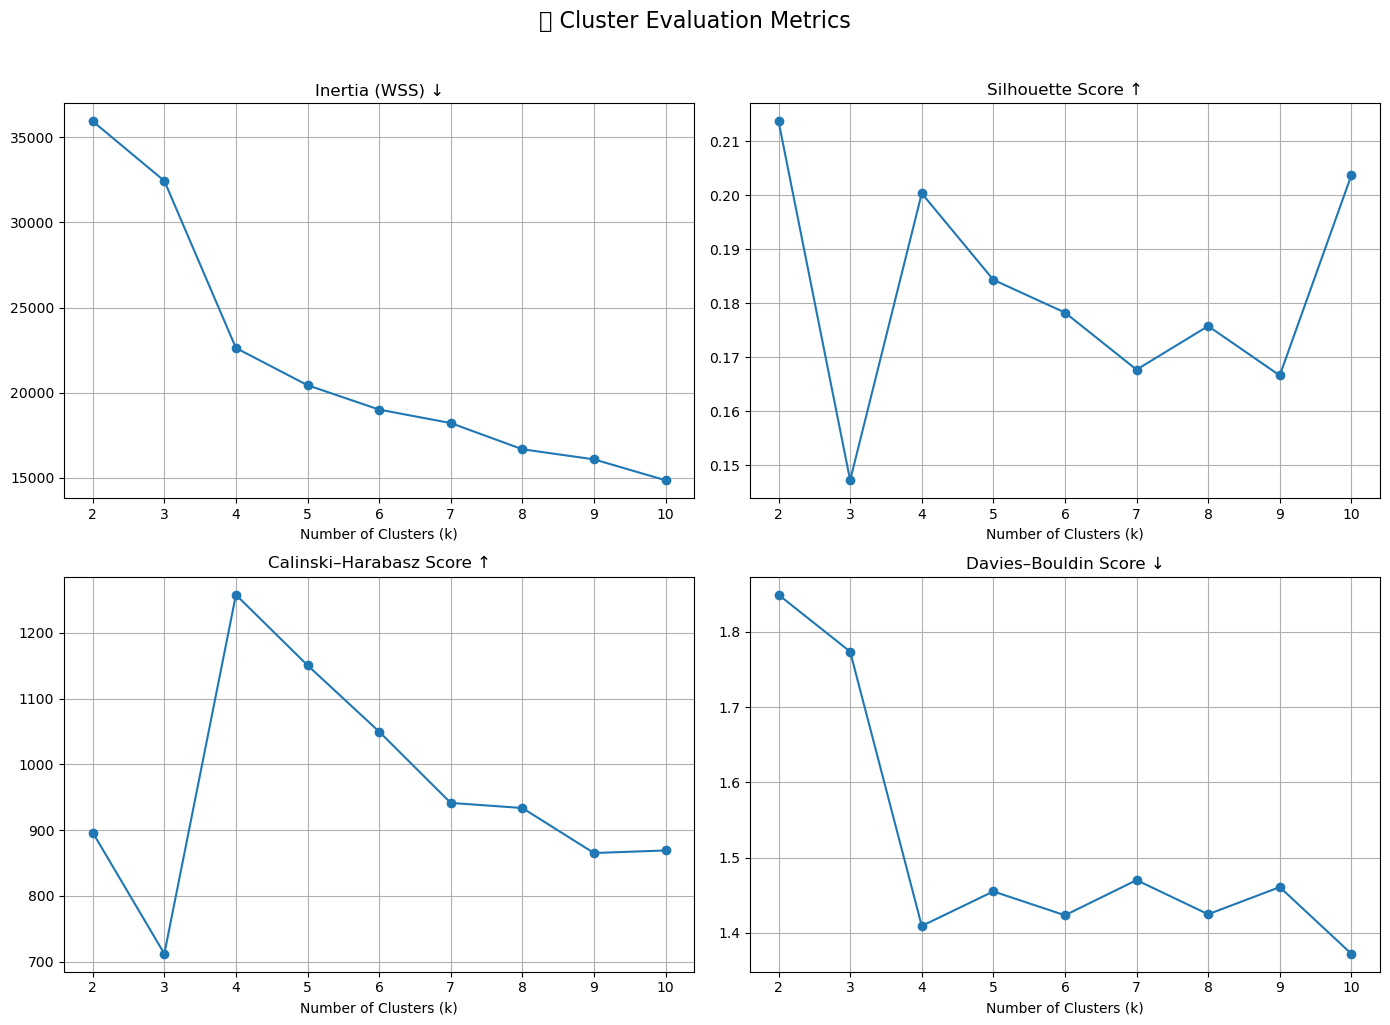

In [15]:
evaluate_all_cluster_scores(df, vars_list, k_range=range(2, 11))

#### Elbow Plot

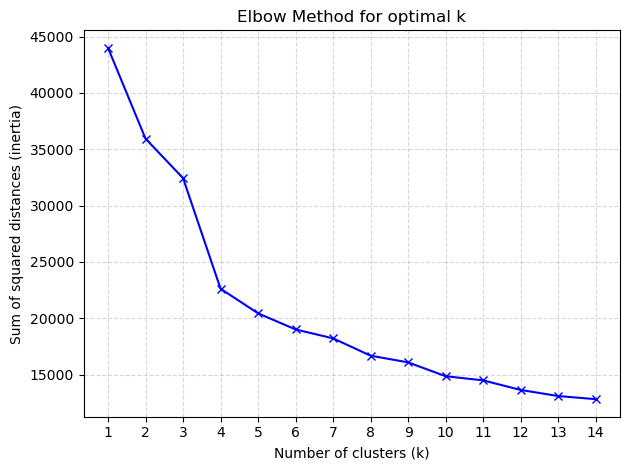

In [4]:
plot_elbow(df, vars_list, k_max=15)

#### Cluster Histogram

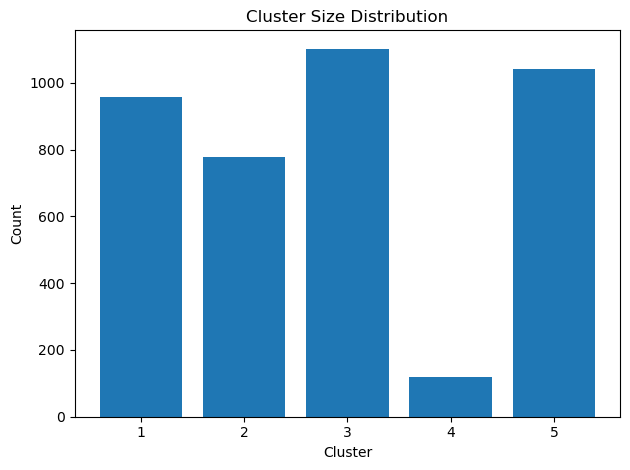

In [5]:
plot_cluster_histogram(df, n_clusters=n)

#### Variable Histograms

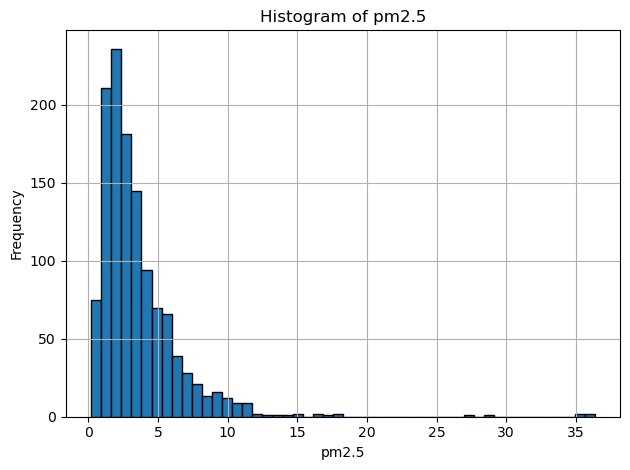

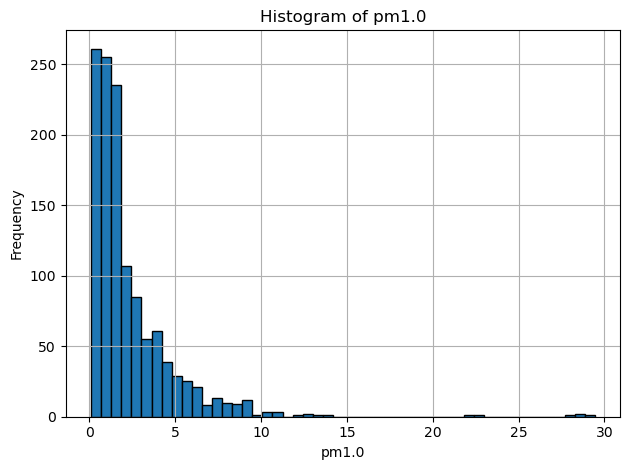

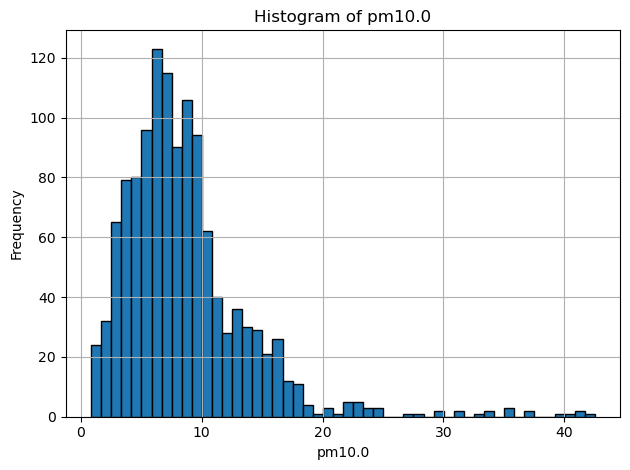

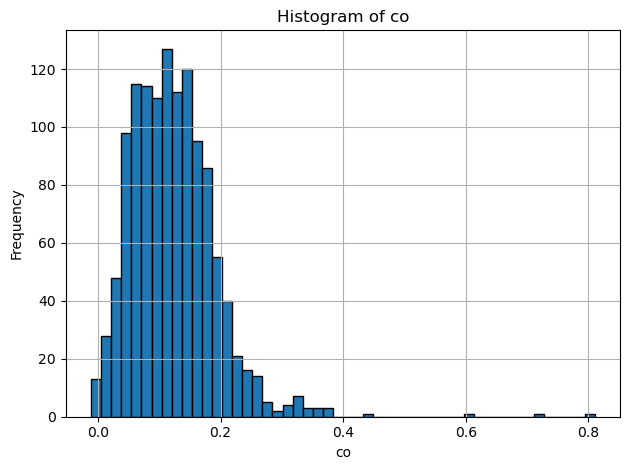

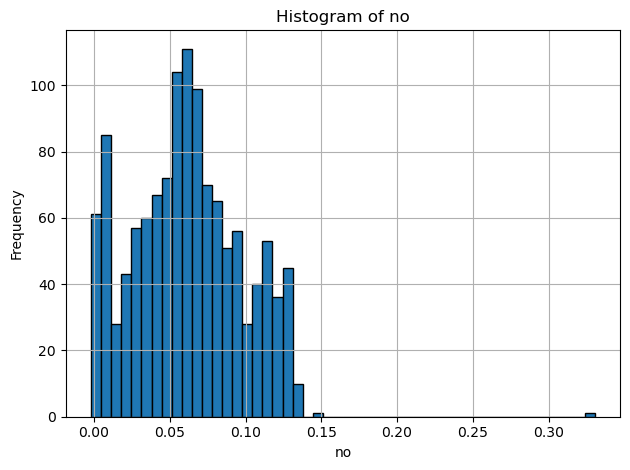

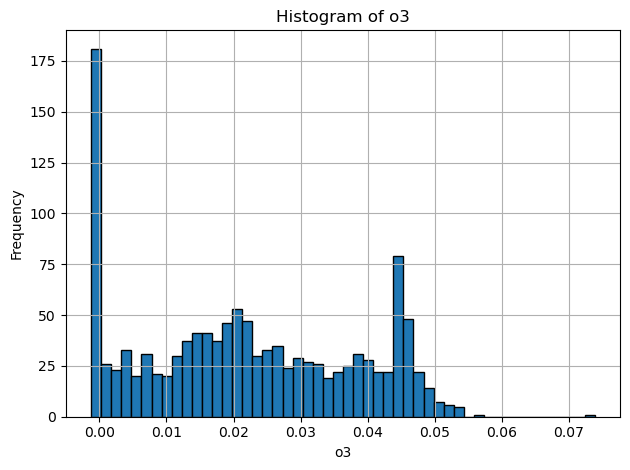

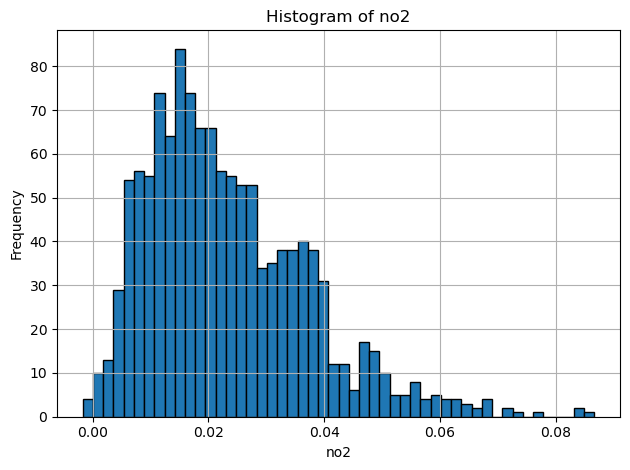

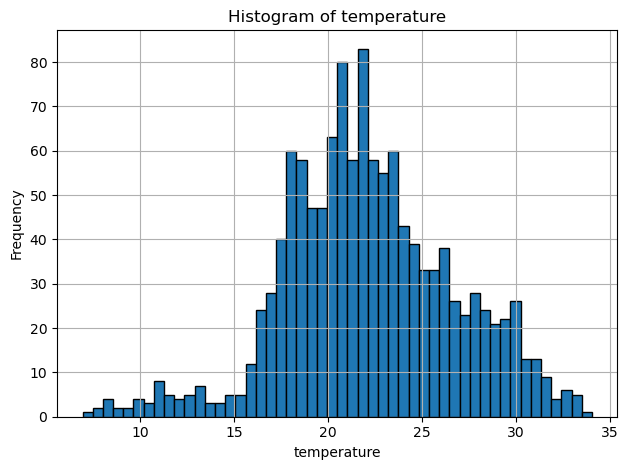

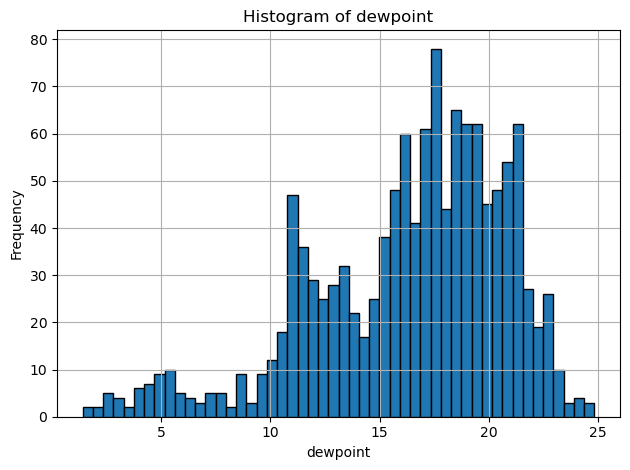

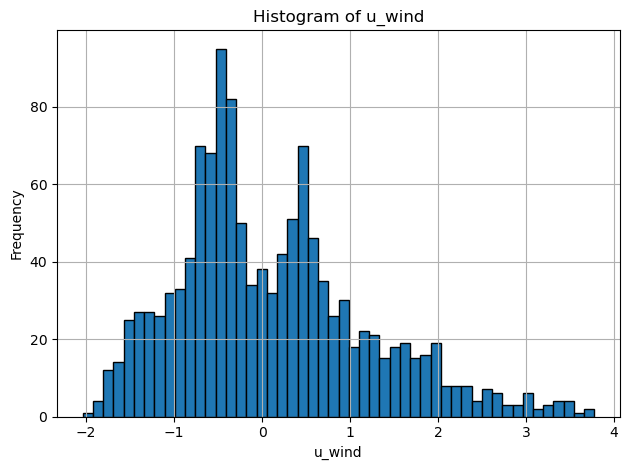

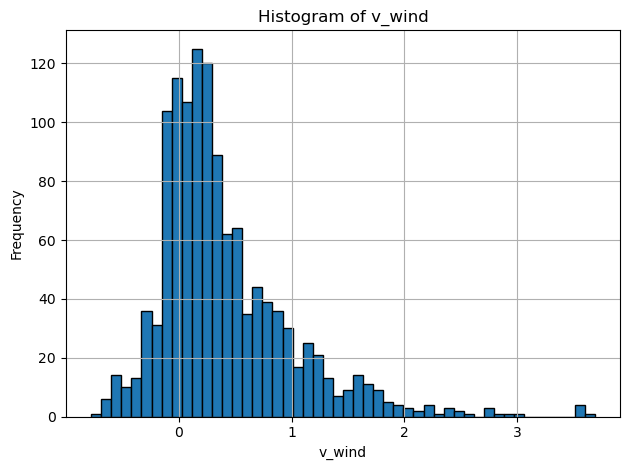

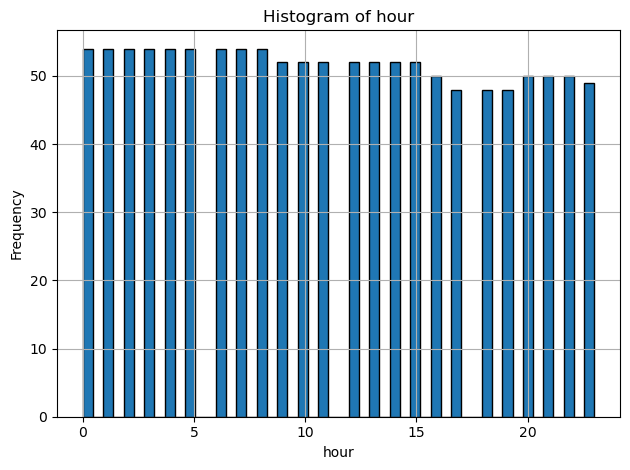

In [16]:
plot_all_variable_histograms(df)

#### Boxplots by Cluster

Where would you like to save the figures (type None if saving is not needed):  D://Figures


Saved D://Figures\box_pm2.5.png


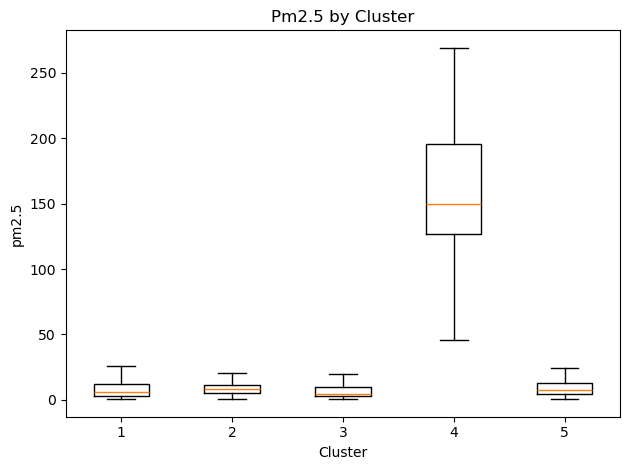

Saved D://Figures\box_pm1.0.png


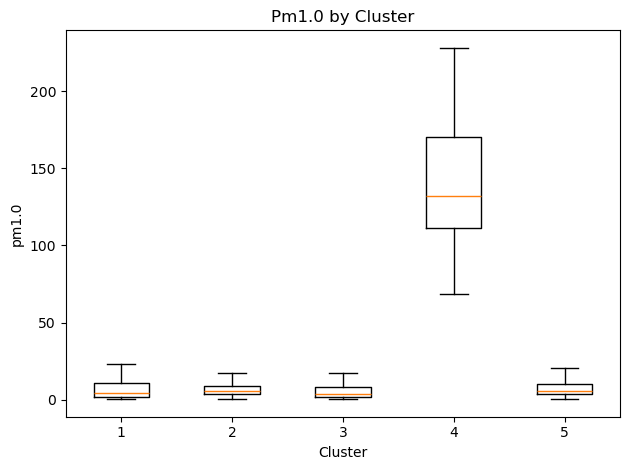

Saved D://Figures\box_pm10.0.png


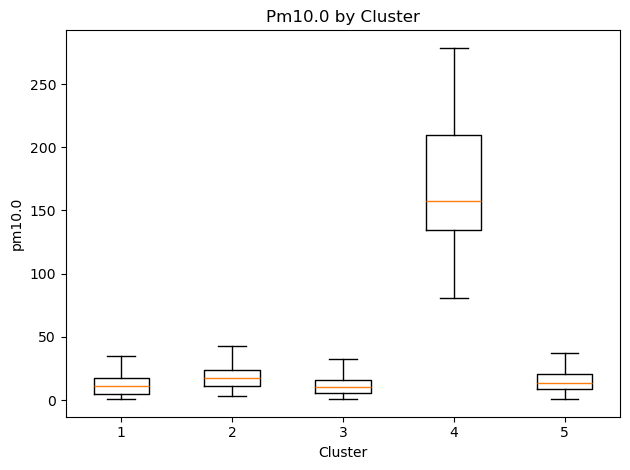

Saved D://Figures\box_co.png


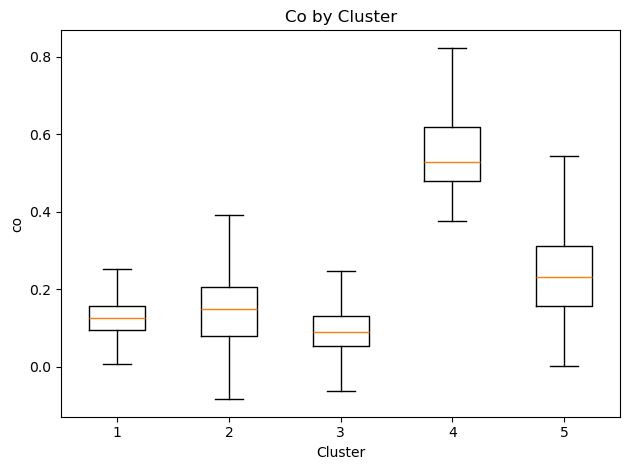

Saved D://Figures\box_no.png


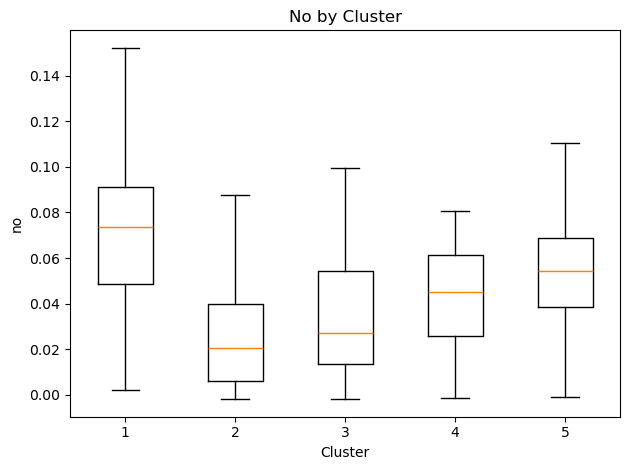

Saved D://Figures\box_o3.png


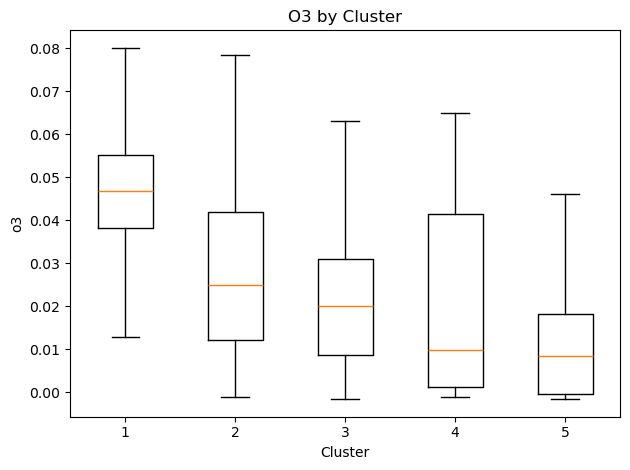

Saved D://Figures\box_no2.png


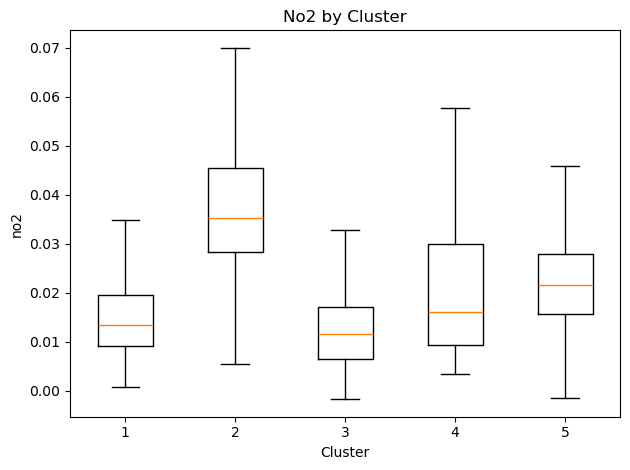

Saved D://Figures\box_temperature.png


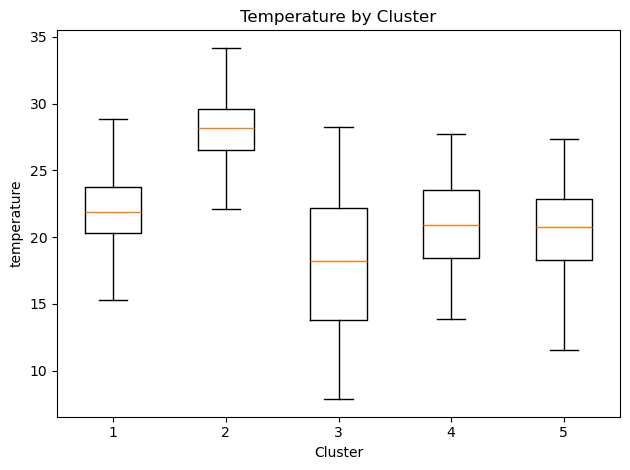

Saved D://Figures\box_dewpoint.png


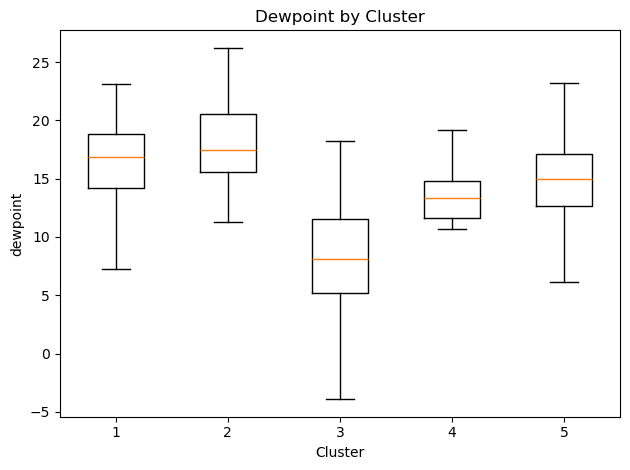

Saved D://Figures\box_u_wind.png


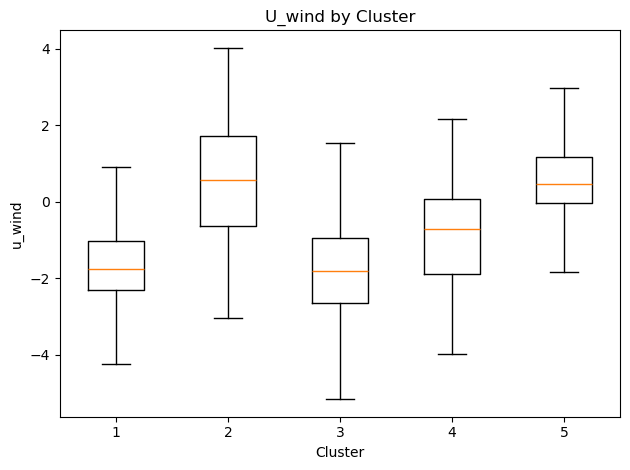

Saved D://Figures\box_v_wind.png


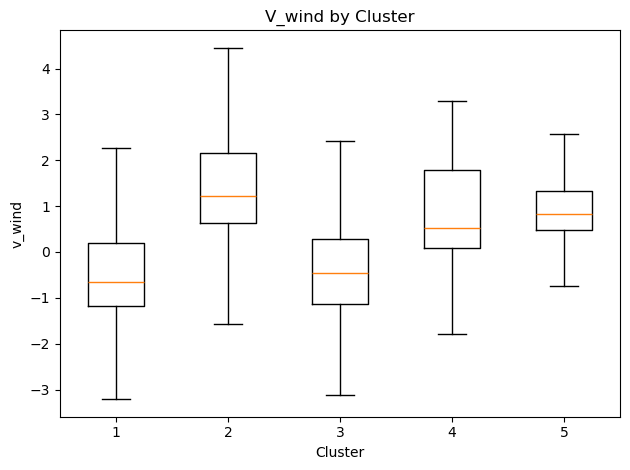

In [12]:
output_dir = input('Where would you like to save the figures (type None if saving is not needed): ').strip()
plot_box_time(df, vars_list, output_dir)

#### Boxplots in 1 Figure

Saved boxplot grid to 'D://Figures//boxplots_by_cluster_v4.png'


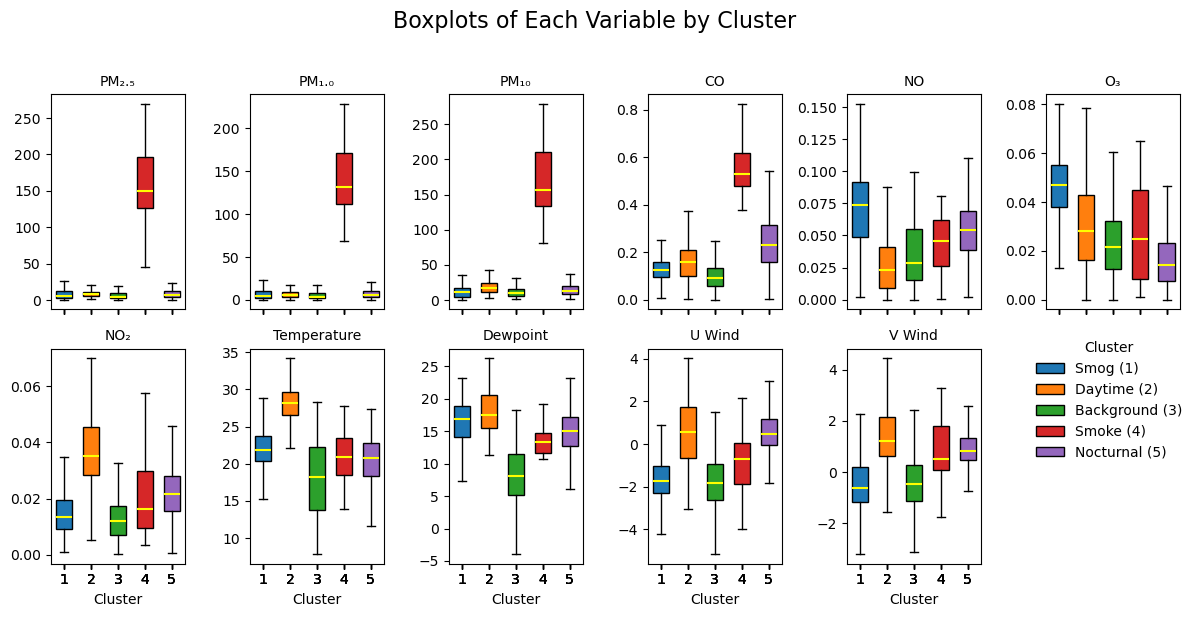

In [32]:
display_names = {
    **{v: v for v in variables},
    'pm2.5':      'PM₂.₅',
    'pm1.0':      'PM₁.₀',
    'pm10.0':     'PM₁₀',
    'co':         'CO',
    'no':         'NO',
    'o3':         'O₃',
    'no2':        'NO₂',
    'temperature':'Temperature',
    'dewpoint':   'Dewpoint',
    'u_wind':     'U Wind',
    'v_wind':     'V Wind',
}

cluster_names = {
    1: 'Smog (1)',
    2: 'Daytime (2)',
    3: 'Background (3)',
    4: 'Smoke (4)',
    5: 'Nocturnal (5)',
}

palette = sns.color_palette("tab10", len(cluster_names))
cluster_colors = {cid: palette[i] for i, cid in enumerate(cluster_names)}

plot_all_boxplots_by_cluster(
    df,
    variables,
    n_clusters=5,
    cluster_colors=cluster_colors,
    cluster_names=cluster_names,
    display_names=display_names,
    nonneg_vars={'pm2.5','pm1.0','pm10.0','co','no','o3','no2'},
    n_cols=6,
    figsize=(12,6),
    output_path="D://Figures//boxplots_by_cluster_v4.png"
)

#### Multifigure

C:\Users\video\AppData\Local\Temp\ipykernel_43024\3491097077.py:620: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(counts.index, rotation=30, ha='right')
C:\Users\video\AppData\Local\Temp\ipykernel_43024\3491097077.py:692: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax3.axvspan(pd.to_datetime(start),
C:\Users\video\AppData\Local\Temp\ipykernel_43024\3491097077.py:719: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(facecolor="none",   edgecolor="red", color='red', linewidth=1.5, alpha = 0.3, label="Intense Wildfire Smoke"),
C:\Users\video\AppData\Local\Temp\ipykernel_43024\3491097077.py:731: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


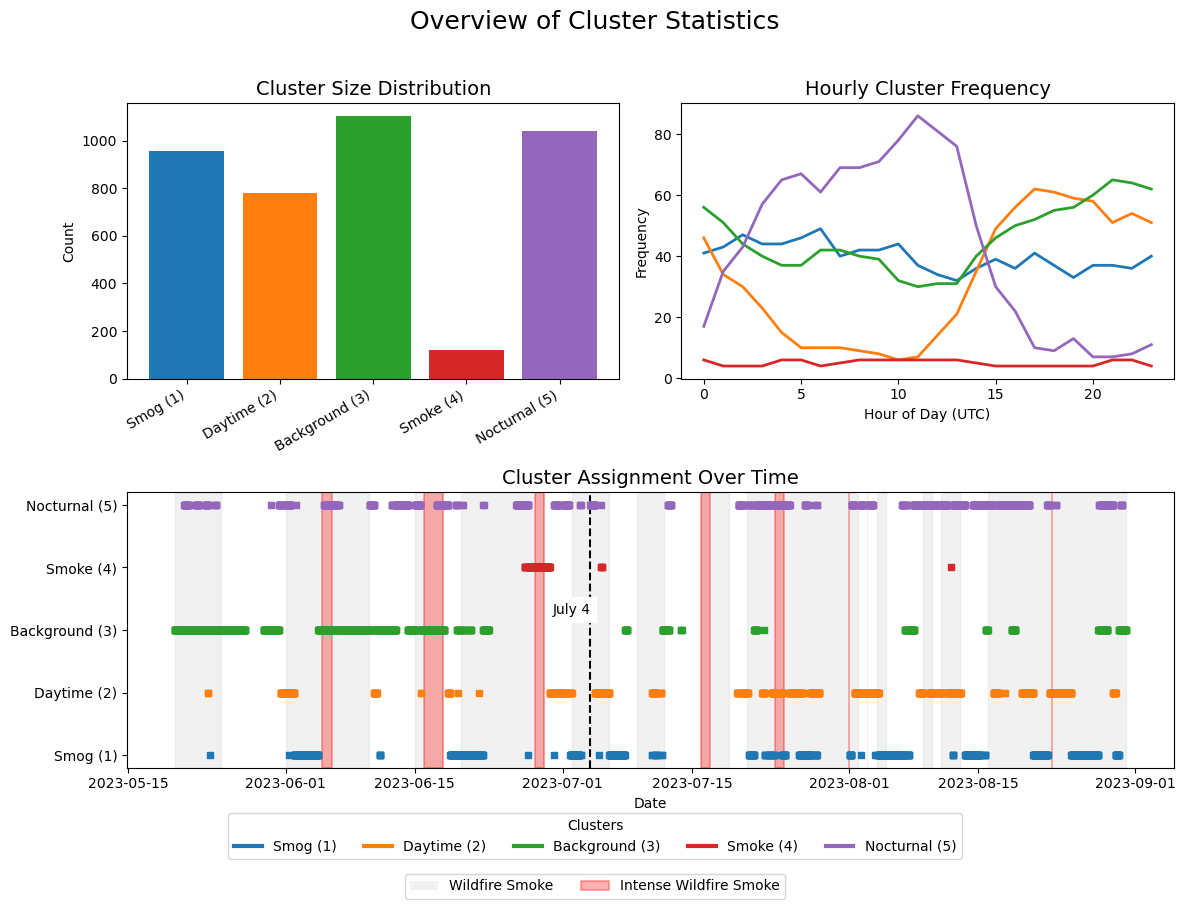

In [22]:
multifig(df)

#### Pairplot

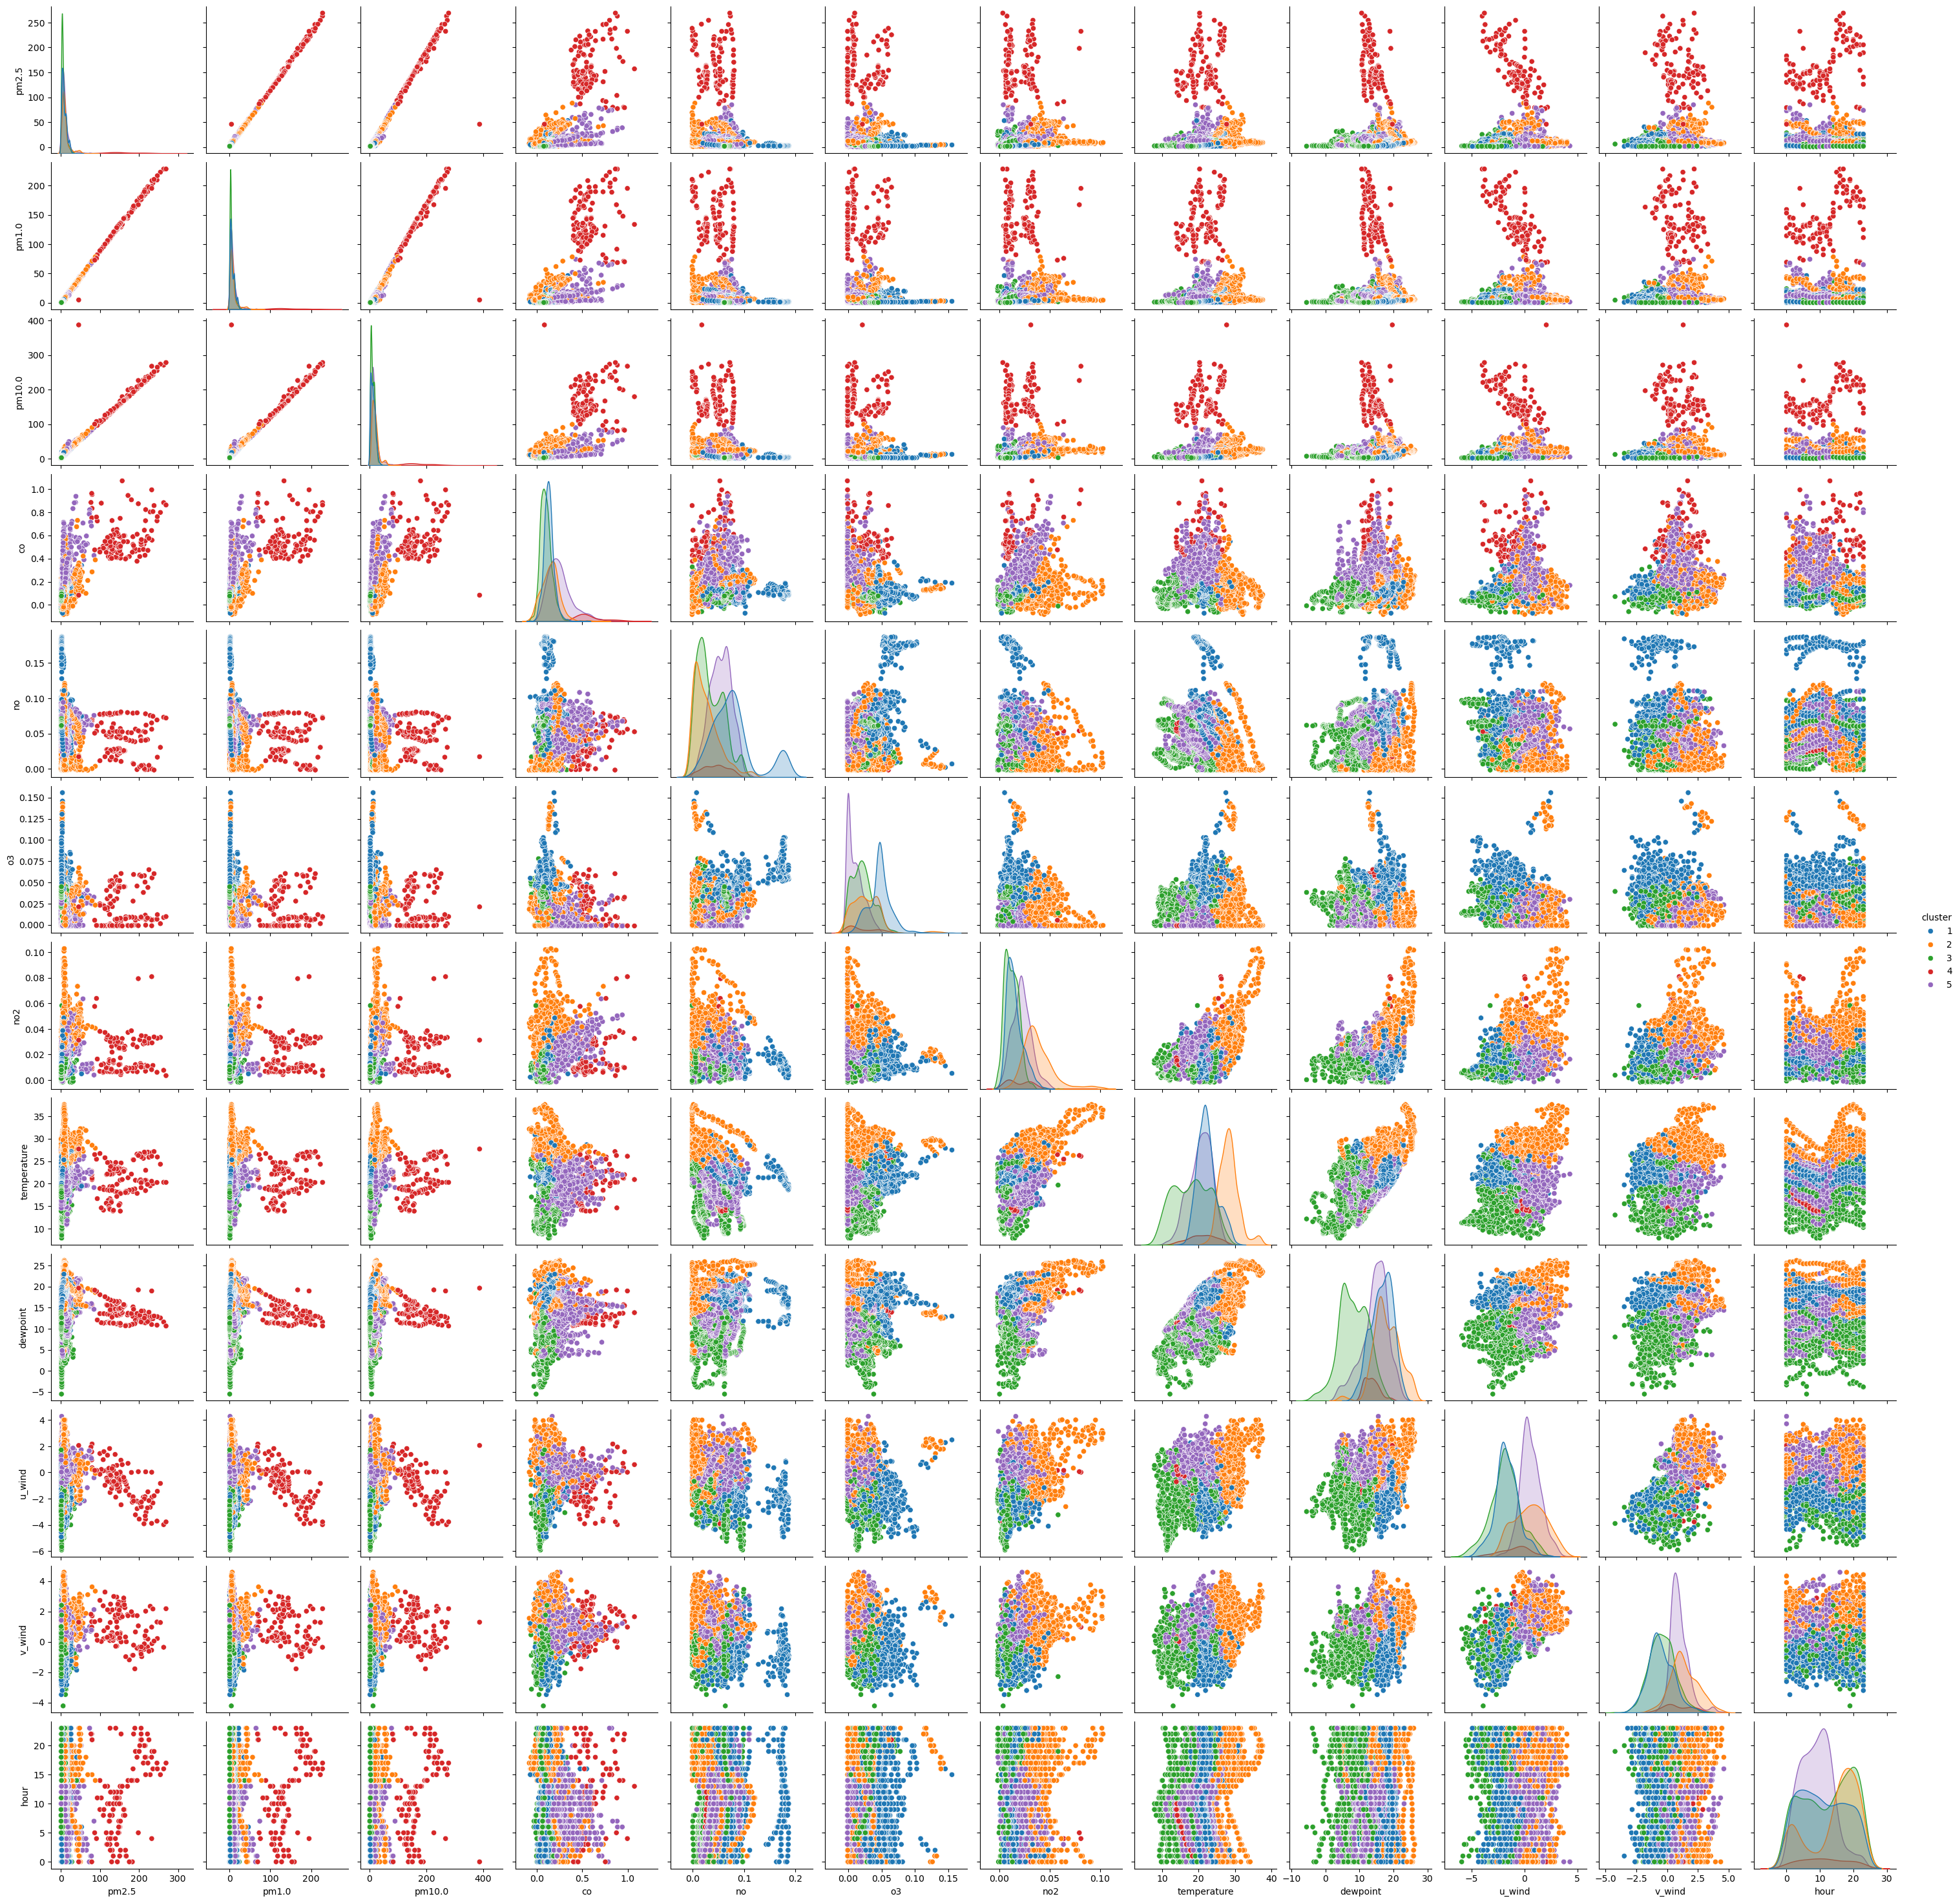

In [7]:
plot_variable_pairs(df, n_clusters=n)

#### Mosaic Plot (Hour vs. Cluster)

<Figure size 800x600 with 0 Axes>

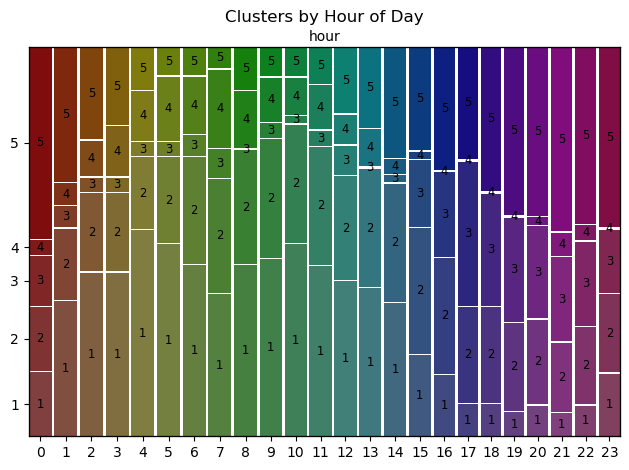

In [19]:
mosaic_plot(df, 'hour', 'cluster', title="Clusters by Hour of Day")

#### Variable Importance Bar Chart

C:\Users\video\.conda\envs\my_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


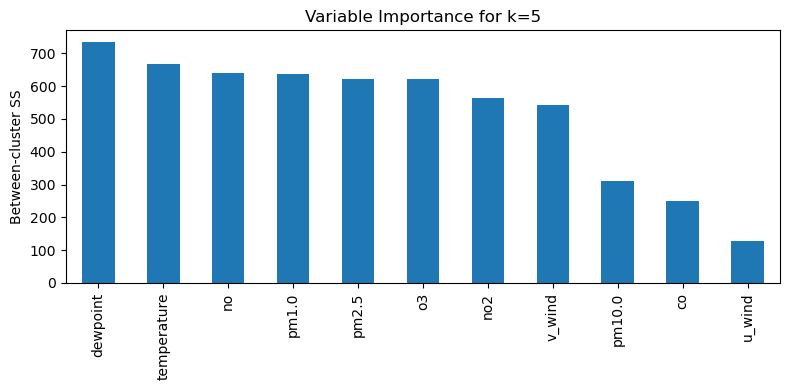

In [20]:
imp = variable_importance_bss(df, vars_list, n_clusters=n)

plt.figure(figsize=(8,4))
imp.plot(kind='bar')
plt.ylabel('Between-cluster SS')
plt.title(f'Variable Importance for k={n}')
plt.tight_layout()
plt.show()

#### Per‐Cluster Treemaps

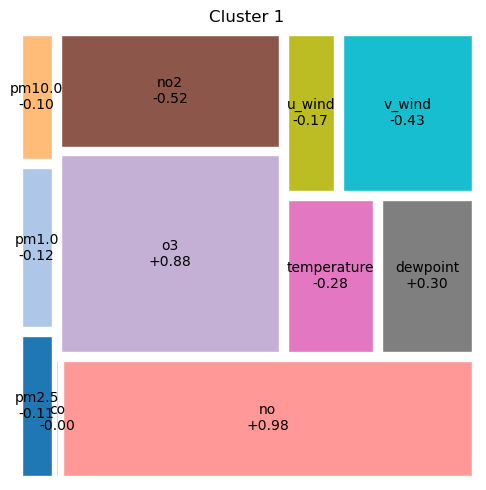

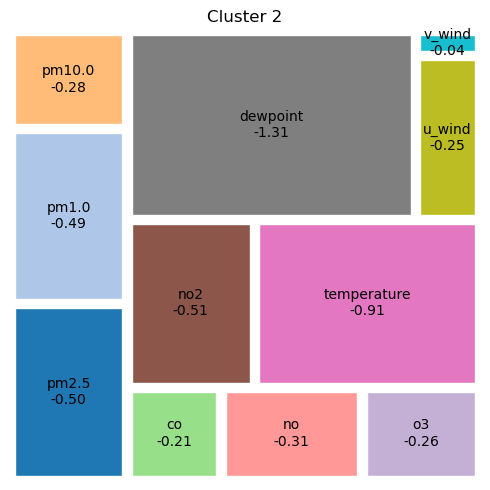

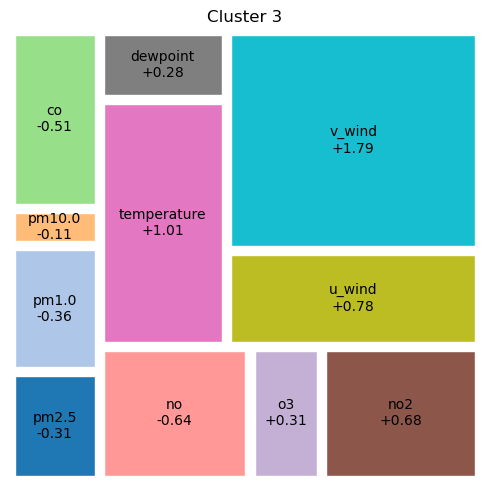

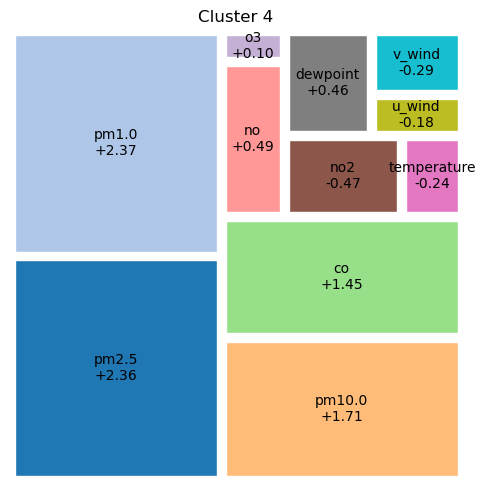

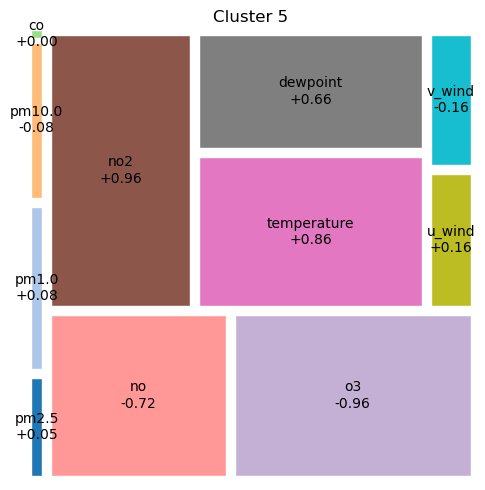

In [21]:
plot_per_cluster_treemaps(km, vars_list, n_clusters=n)

#### All cluster treemaps

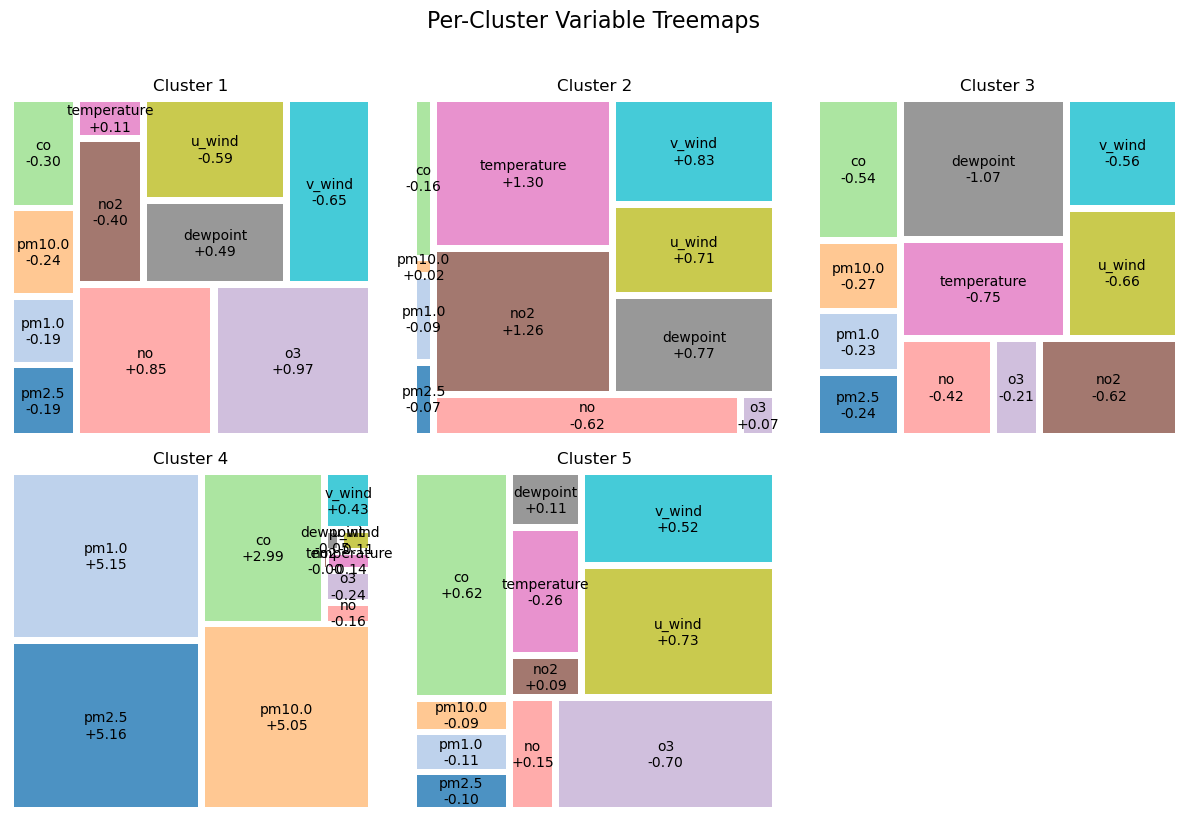

In [54]:
plot_all_cluster_treemaps(km, vars_list, n_clusters=n, cols=3)

#### All cluster treemaps redo

C:\Users\video\AppData\Local\Temp\ipykernel_43024\3921540189.py:1008: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


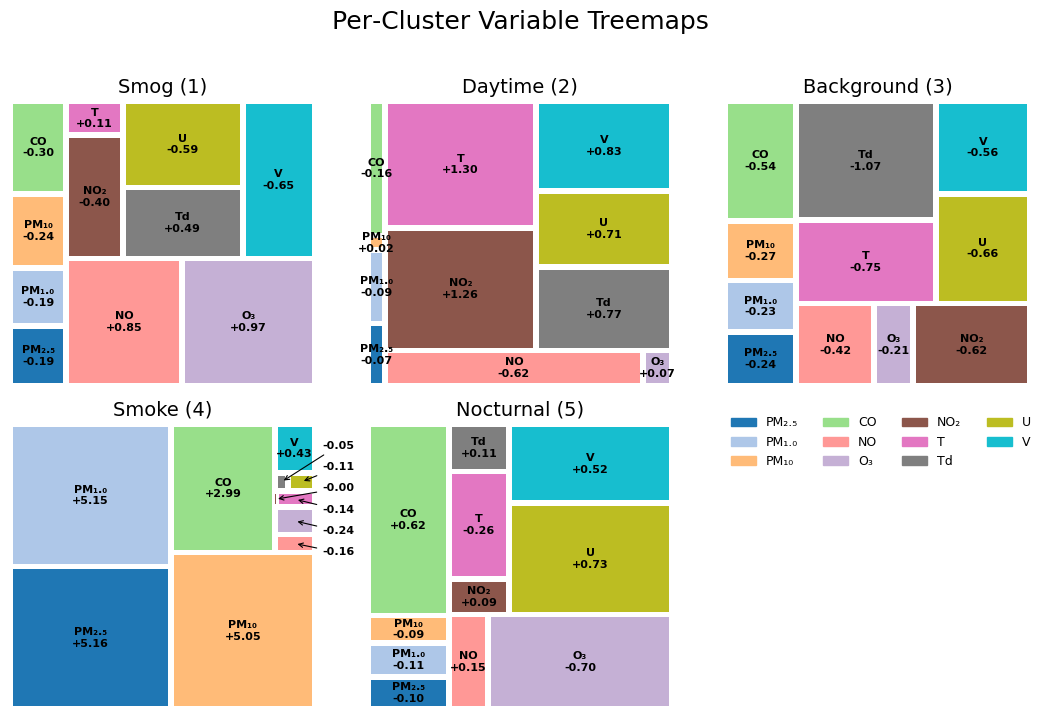

In [13]:
variables = vars_list

cluster_labels = {
    1: "Smog (1)",
    2: "Daytime (2)",
    3: "Background (3)",
    4: "Smoke (4)",
    5: "Nocturnal (5)",
}

new_plot_all_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=n, cols=3,
    small_area_threshold=150.0,
    arrow_x_offset=2.5,
    arrow_y_offset=0)

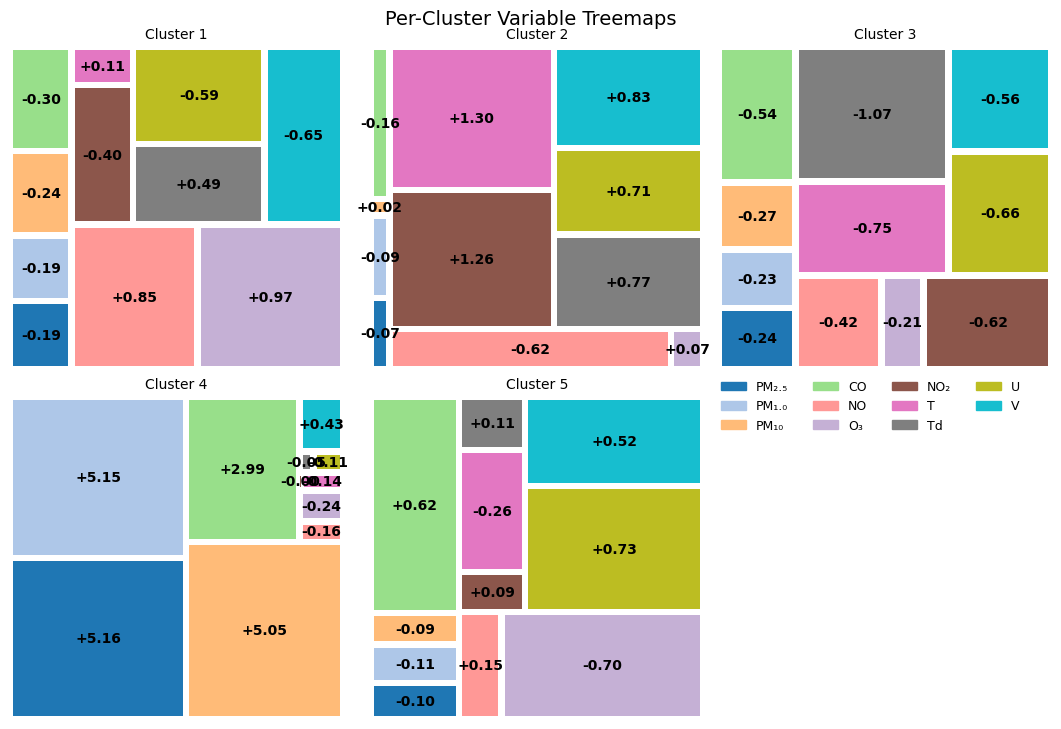

In [94]:
cluster_annotations = {
    cid+1: {
        v: f"{km.cluster_centers_[cid,i]:+.2f}"
        for i,v in enumerate(variables)
    }
    for cid in range(km.n_clusters)
}

new_plot_all_cluster_treemaps(
    km,
    variables,
    cluster_annotations,
    n_clusters=n,
    cols=3
)

#### All cluster treemaps experimentation

In [128]:
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch

def plot_per_cluster_treemaps(km, variables, cluster_annotations,
                              n_clusters=5, cols=3,
                              small_area_threshold=200.0):
    """
    km                 : fitted KMeans model
    variables          : list of feature names in the order you trained on
    cluster_annotations: dict of dicts, e.g.
                        { cid: { var: "+0.12", … }, … }
    """
    # 1) pick one color per variable
    cmap       = plt.get_cmap('tab20')
    colors     = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = {v:colors[i] for i,v in enumerate(variables)}

    # 2) compute *one* layout
    unit_sizes = [1]*len(variables)
    base_rects = squarify.squarify(unit_sizes, 0,0,100,100)

    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # 3) draw each cluster with a single call to squarify.plot()
    for cid in range(1, n_clusters+1):
        ax     = axes[cid-1]
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes /= sizes.sum()
        sizes *= 100

         # labels = just the "+0.XX" strings
        labels = [cluster_annotations[cid][v] for v in variables]
        
        # this builds all the rectangles in one go
        squarify.plot(
            sizes=sizes,
            label=None,               # we’ll add our own labels below
            color=[var_colors[v] for v in variables],
            ax=ax,
            pad=True
        )

        ax.set_title(f"Cluster {cid}", fontsize=10, pad=6)
        ax.axis('off')

    # 4) *One* loop over the patches of Cluster 4 to add arrows
    ax4    = axes[4-1]           # cluster 4’s axis
    patches = ax4.patches       # list of Rectangle artists
    annots  = [cluster_annotations[4][v] for v in variables]

    for patch, txt in zip(patches, annots):
        area = patch.get_width()*patch.get_height()
        cx   = patch.get_x() + patch.get_width()/2
        cy   = patch.get_y() + patch.get_height()/2

        if area < small_area_threshold:
            # “pull out” small ones
            ax4.annotate(
                txt,
                xy=(cx, cy),
                xytext=(cx + 10, cy),
                arrowprops=dict(arrowstyle='->', lw=1),
                va='center', fontsize=8, weight='bold'
            )
        else:
            ax4.text(
                cx, cy, txt,
                ha='center', va='center',
                fontsize=8, weight='bold'
            )

    # 5) turn off any unused subplots
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # 6) single legend
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(color=var_colors[v], label=v.upper())
        for v in variables
    ]
    fig.legend(
        handles=legend_handles,
        ncol=4,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        frameon=False,
        fontsize=9
    )

    fig.suptitle("Per-Cluster Variable Treemaps", y=1.02, fontsize=14)
    plt.show()

# build your cluster_annotations dict just once:
cluster_annotations = {
    cid+1: {
        v: f"{km.cluster_centers_[cid,i]:+.2f}"
        for i,v in enumerate(variables)
    }
    for cid in range(km.n_clusters)
}

plot_per_cluster_treemaps(
    km, variables, cluster_annotations,
    n_clusters=5, cols=3,
    small_area_threshold=300.0
)import numpy as np
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch

def plot_per_cluster_treemaps(km, variables, cluster_annotations,
                              n_clusters=5, cols=3,
                              small_area_threshold=200.0):
    """
    Draw per-cluster treemaps with consistent colors,
    and pull out very small boxes (esp. +0.00) to avoid overlap.
    """
    # 1) pick one color per variable
    cmap       = plt.get_cmap('tab20')
    palette    = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = {v: palette[i] for i,v in enumerate(variables)}

    # 2) compute a “unit” layout once (we just need the geometry)
    _ = squarify.squarify([1]*len(variables), 0,0,100,100)

    # 3) set up figure
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # 4) draw each cluster
    for cid in range(1, n_clusters+1):
        ax     = axes[cid-1]
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes / sizes.sum() * 100

        squarify.plot(
            sizes=sizes,
            label=None,  # we add our own labels below
            color=[var_colors[v] for v in variables],
            ax=ax, pad=True
        )
        ax.set_title(f"Cluster {cid}", fontsize=10, pad=6)
        ax.axis('off')

    # 5) gather everything for one pass of annotations
    annotations = [
        (
            ax, patch,
            cluster_annotations[cid][var],
            patch.get_width()*patch.get_height(),
            patch.get_x()+patch.get_width()/2,
            patch.get_y()+patch.get_height()/2
        )
        for cid, ax in enumerate(axes[:n_clusters], start=1)
        for patch, var in zip(ax.patches, variables)
    ]

    # 6) place text or arrows (special-case "+0.00")
    for ax, patch, txt, area, cx, cy in annotations:
        if area < small_area_threshold:
            # for the tiny zero‐box, always pull upper-left:
            if txt == "+0.00":
                dx, dy = -30, +15
            else:
                # default small offset
                dx, dy = +10, 0

            ax.annotate(
                txt,
                xy=(cx, cy),
                xytext=(cx + dx, cy + dy),
                arrowprops=dict(arrowstyle='->', lw=1, color='black'),
                va='center', ha='center',
                fontsize=8, weight='bold'
            )
        else:
            ax.text(
                cx, cy, txt,
                ha='center', va='center',
                fontsize=8, weight='bold'
            )

    # 7) turn off any unused subplots
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # 8) one shared legend
    legend_handles = [
        Patch(color=var_colors[v], label=v.upper())
        for v in variables
    ]
    fig.legend(
        handles=legend_handles,
        ncol=4,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        frameon=False,
        fontsize=9
    )

    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
    plt.show()


# ------------------------------------------------------------------
# build your cluster_annotations dict **once**, forcing "+0.00"
cluster_annotations = {
    cid+1: {
        v: (
            "+0.00"
            if abs(round(km.cluster_centers_[cid,i], 2)) < 1e-6
            else f"{km.cluster_centers_[cid,i]:+.2f}"
        )
        for i, v in enumerate(variables)
    }
    for cid in range(km.n_clusters)
}


# finally, call it:
plot_per_cluster_treemaps(
    km, variables, cluster_annotations,
    n_clusters=5, cols=3,
    small_area_threshold=150.0
)


SyntaxError: invalid syntax (3685628189.py, line 113)

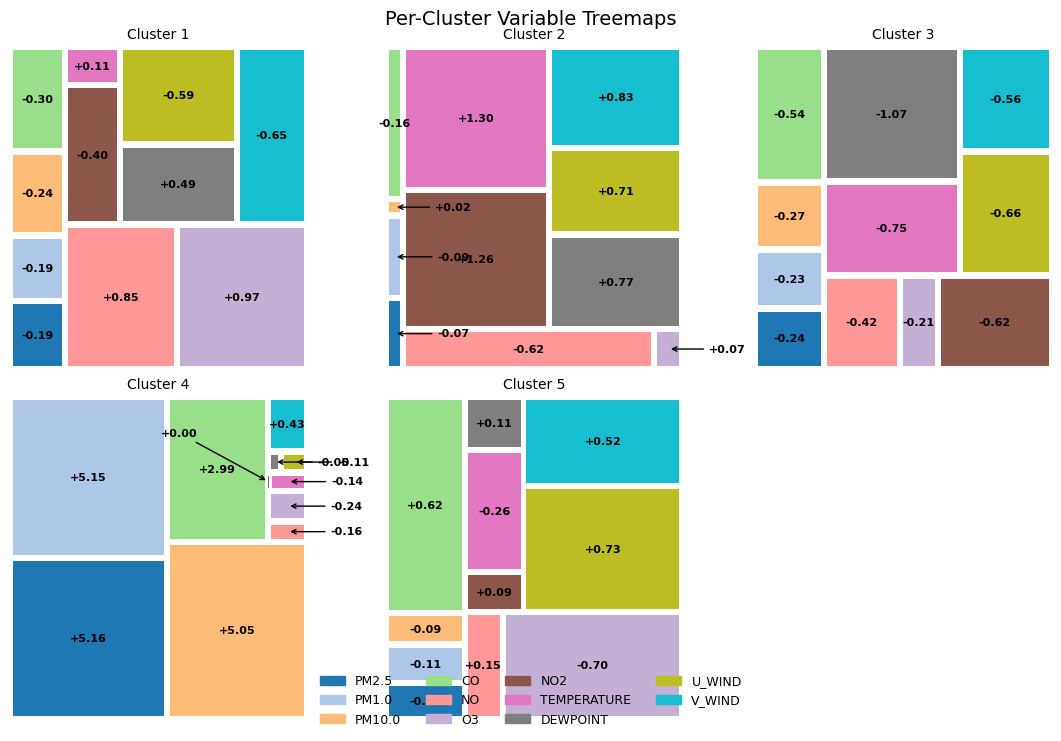

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch

def plot_per_cluster_treemaps(km, vars_list, cluster_annotations,
                              n_clusters=5, cols=3,
                              small_area_threshold=200.0):
    """
    Draw per-cluster treemaps with consistent colors,
    and pull out very small boxes (esp. +0.00) to avoid overlap.
    """
    # 1) pick one color per variable
    cmap       = plt.get_cmap('tab20')
    palette    = [cmap(i/len(vars_list)) for i in range(len(vars_list))]
    var_colors = {v: palette[i] for i,v in enumerate(vars_list)}

    # 2) compute a “unit” layout once (we just need the geometry)
    _ = squarify.squarify([1]*len(vars_list), 0,0,100,100)

    # 3) set up figure
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # 4) draw each cluster
    for cid in range(1, n_clusters+1):
        ax     = axes[cid-1]
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes / sizes.sum() * 100

        squarify.plot(
            sizes=sizes,
            label=None,  # we add our own labels below
            color=[var_colors[v] for v in vars_list],
            ax=ax, pad=True
        )
        ax.set_title(f"Cluster {cid}", fontsize=10, pad=6)
        ax.axis('off')

    # 5) gather everything for one pass of annotations
    annotations = [
        (
            ax, patch,
            cluster_annotations[cid][var],
            patch.get_width()*patch.get_height(),
            patch.get_x()+patch.get_width()/2,
            patch.get_y()+patch.get_height()/2
        )
        for cid, ax in enumerate(axes[:n_clusters], start=1)
        for patch, var in zip(ax.patches, vars_list)
    ]

    # 6) place text or arrows (special-case "+0.00")
    for ax, patch, txt, area, cx, cy in annotations:
        if area < small_area_threshold:
            # for the tiny zero‐box, always pull upper-left:
            if txt == "+0.00":
                dx, dy = -30, +15
            else:
                # default small offset
                dx, dy = +20, 0

            ax.annotate(
                txt,
                xy=(cx, cy),
                xytext=(cx + dx, cy + dy),
                arrowprops=dict(arrowstyle='->', lw=1, color='black'),
                va='center', ha='center',
                fontsize=8, weight='bold'
            )
        else:
            ax.text(
                cx, cy, txt,
                ha='center', va='center',
                fontsize=8, weight='bold'
            )

    # 7) turn off any unused subplots
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # 8) one shared legend
    legend_handles = [
        Patch(color=var_colors[v], label=v.upper())
        for v in vars_list
    ]
    fig.legend(
        handles=legend_handles,
        ncol=4,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        frameon=False,
        fontsize=9
    )

    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
    plt.show()


# ------------------------------------------------------------------
# build your cluster_annotations dict **once**, forcing "+0.00"
cluster_annotations = {
    cid+1: {
        v: (
            "+0.00"
            if abs(round(km.cluster_centers_[cid,i], 2)) < 1e-6
            else f"{km.cluster_centers_[cid,i]:+.2f}"
        )
        for i, v in enumerate(vars_list)
    }
    for cid in range(km.n_clusters)
}

def main():
# finally, call it:
    plot_per_cluster_treemaps(km, vars_list, cluster_annotations, n_clusters=5, cols=3, small_area_threshold=150.0)

if __name__ == '__main__':
    main()


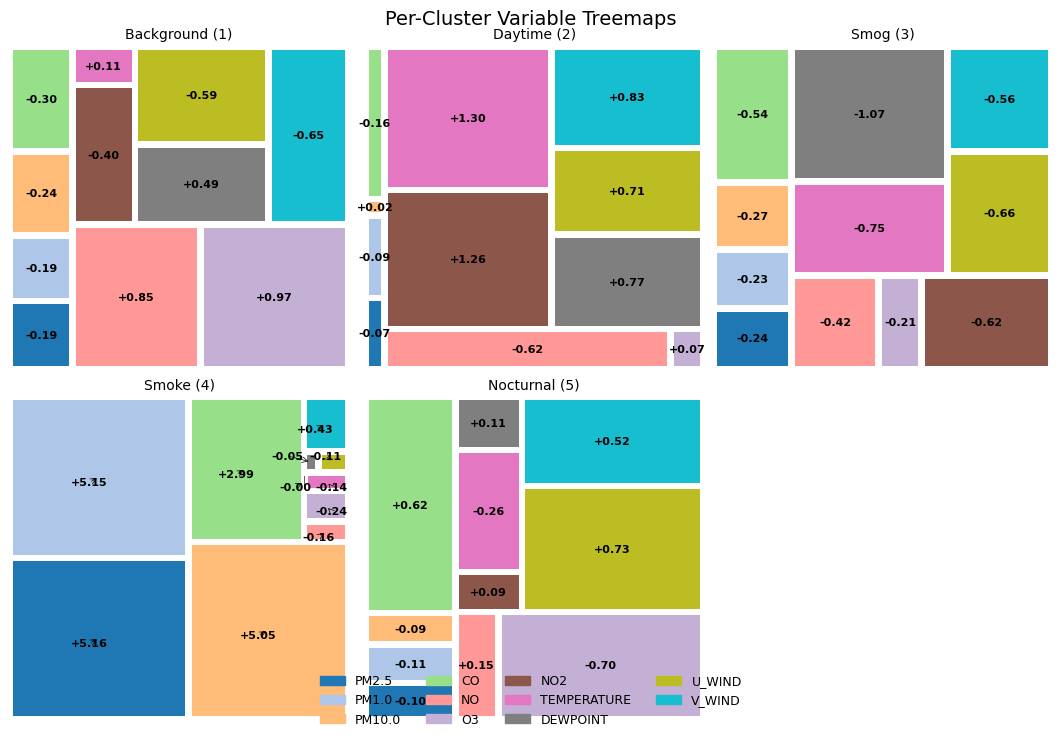

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch
from adjustText import adjust_text

def plot_per_cluster_treemaps(km, variables, cluster_labels,
                              n_clusters=5, cols=3):
    """
    km            : fitted KMeans model
    variables     : list of feature names
    cluster_labels: dict mapping cid→display name
    """
    # pick one color per variable
    cmap    = plt.get_cmap('tab20')
    palette = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = dict(zip(variables, palette))

    # force one squarify layout so the patch order is consistent
    _ = squarify.squarify([1]*len(variables), 0,0,100,100)

    # set up grid
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # we’ll collect *all* Text artists, plus a special list for cluster_4
    all_texts = []
    texts4    = []

    for cid, ax in enumerate(axes[:n_clusters], start=1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes / sizes.sum() * 100

        # draw treemap without labels
        squarify.plot(
            sizes=sizes,
            label=None,
            color=[var_colors[v] for v in variables],
            ax=ax, pad=True
        )

        ax.set_title(cluster_labels[cid], fontsize=10, pad=6)
        ax.axis('off')

        # now *place* every label at its tile center
        for patch, var in zip(ax.patches, variables):
            val = center[variables.index(var)]
            txt = f"{val:+.2f}"
            cx  = patch.get_x() + patch.get_width()/2
            cy  = patch.get_y() + patch.get_height()/2

            t = ax.text(cx, cy, txt,
                        ha='center', va='center',
                        fontsize=8, weight='bold',
                        color='black')
            all_texts.append(t)
            if cid == 4:
                texts4.append(t)

    # only nudge the tiny labels in cluster 4 outwards
    adjust_text(
        texts4,
        ax=axes[3],  # axis index 3 is cluster 4
        xpand_text=(1.2,1.2),
        force_text=(0.1, 0.1),
        autoalign='xy',
        arrowprops=dict(arrowstyle='->', color='black', lw=0.5),
        only_move={'text':'xy'}
    )

    # 7) turn off extras
    for ax in axes[n_clusters:]:
        ax.axis('off')
        
    # finally, a single legend for the whole figure
    handles = [Patch(color=var_colors[v], label=v.upper())
               for v in variables]
    fig.legend(handles=handles, ncol=4,
               loc='lower center', bbox_to_anchor=(0.5, -0.02),
               frameon=False, fontsize=9)

    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
    plt.show()

    
variables = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2',
             'temperature','dewpoint','u_wind','v_wind']

cluster_labels = {
    1: "Background (1)",
    2: "Daytime (2)",
    3: "Smog (3)",
    4: "Smoke (4)",
    5: "Nocturnal (5)",
}

plot_per_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=5, cols=3
)

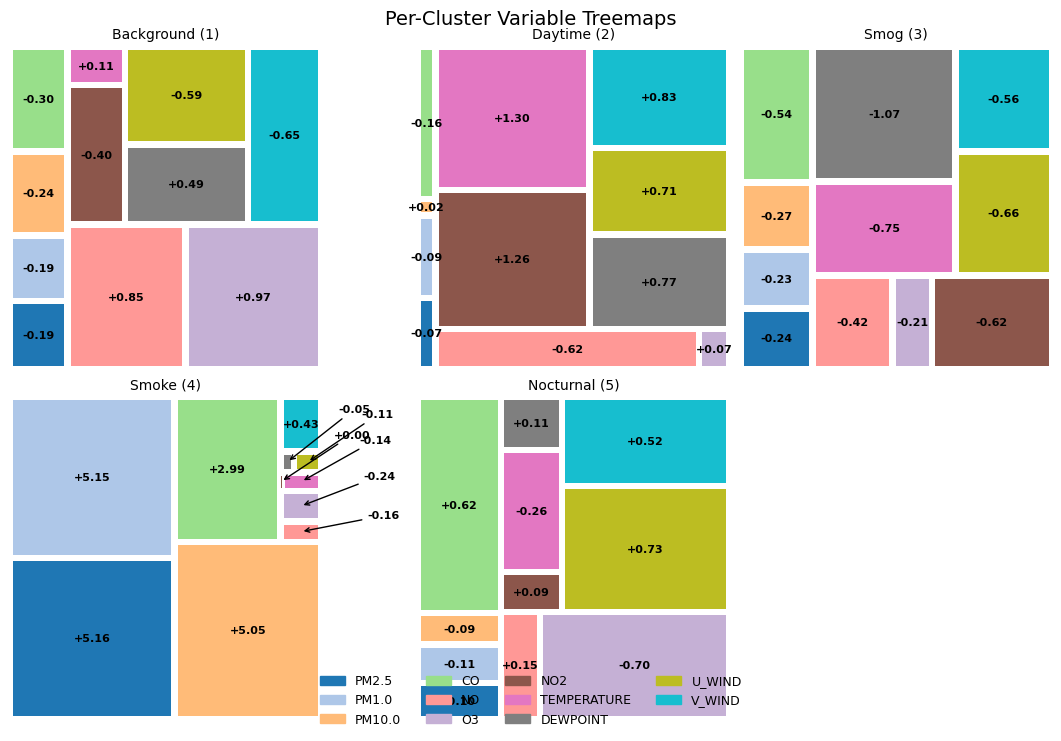

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch

def plot_per_cluster_treemaps(km, variables, cluster_labels,
                              n_clusters=5, cols=3,
                              small_area_threshold=200.0, arrow_length=12.0):
    """
    km              : fitted KMeans model
    variables       : list of feature names (in the order you trained on)
    cluster_labels  : dict mapping cluster_id → display name, e.g.
                      {1:"Smog (1)", 2:"Daytime (2)", …}
    n_clusters      : number of clusters (e.g. 5)
    cols            : how many columns in the grid
    small_area_threshold: pull-out cutoff
    arrow_length    : how far to pull small labels in cluster 4
    """
    # 1) one color per variable, force a squarify layout pass
    cmap    = plt.get_cmap('tab20')
    palette = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = dict(zip(variables, palette))
    _ = squarify.squarify([1]*len(variables), 0,0,100,100)

    # 2) figure+axes
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # 3) draw each treemap
    for cid, ax in enumerate(axes[:n_clusters], start=1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes/sizes.sum()*100

        squarify.plot(
            sizes=sizes,
            label=None,
            color=[var_colors[v] for v in variables],
            ax=ax, pad=True
        )
        # **here** use your custom label:
        ax.set_title(cluster_labels.get(cid, f"Cluster {cid}"), fontsize=10, pad=6)
        ax.axis('off')

    # 4) collect raw values
    cats = {
        cid+1: {
            v: km.cluster_centers_[cid,i]
            for i,v in enumerate(variables)
        }
        for cid in range(km.n_clusters)
    }

    # 5) gather everything into one flat list
    annots = []
    for cid, ax in enumerate(axes[:n_clusters], start=1):
        for patch, var in zip(ax.patches, variables):
            val  = cats[cid][var]
            area = patch.get_width()*patch.get_height()
            cx   = patch.get_x() + patch.get_width()/2
            cy   = patch.get_y() + patch.get_height()/2
            annots.append((cid, ax, patch, val, area, cx, cy))

    # 6) one pass to annotate
    for cid, ax, patch, val, area, cx, cy in annots:
        # force “-0.00” → “+0.00” only in cluster 4
        if cid==4 and abs(val)<0.005:
            txt = "+0.00"
        else:
            txt = f"{val:+.2f}"

        if cid==4 and area < small_area_threshold:
            # radial pull-out
            vx, vy = cx-50.0, cy-50.0
            r = np.hypot(vx, vy) or 1.0
            dx, dy = vx/r*arrow_length, vy/r*arrow_length

            ax.annotate(
                txt,
                xy=(cx, cy),
                xytext=(cx+dx, cy+dy),
                arrowprops=dict(arrowstyle='->', lw=1, color='black'),
                ha='center', va='center',
                fontsize=8, weight='bold'
            )
        else:
            ax.text(
                cx, cy, txt,
                ha='center', va='center',
                fontsize=8, weight='bold'
            )

    # 7) turn off extras
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # 8) shared legend
    handles = [Patch(color=var_colors[v], label=v.upper())
               for v in variables]
    fig.legend(
        handles=handles, ncol=4,
        loc='lower center', bbox_to_anchor=(0.5,-0.02),
        frameon=False, fontsize=9
    )

    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
    plt.show()
    
variables = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2',
             'temperature','dewpoint','u_wind','v_wind']

cluster_labels = {
    1: "Background (1)",
    2: "Daytime (2)",
    3: "Smog (3)",
    4: "Smoke (4)",
    5: "Nocturnal (5)",
}

plot_per_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=5, cols=3,
    small_area_threshold=150.0,
    arrow_length=27.0
)


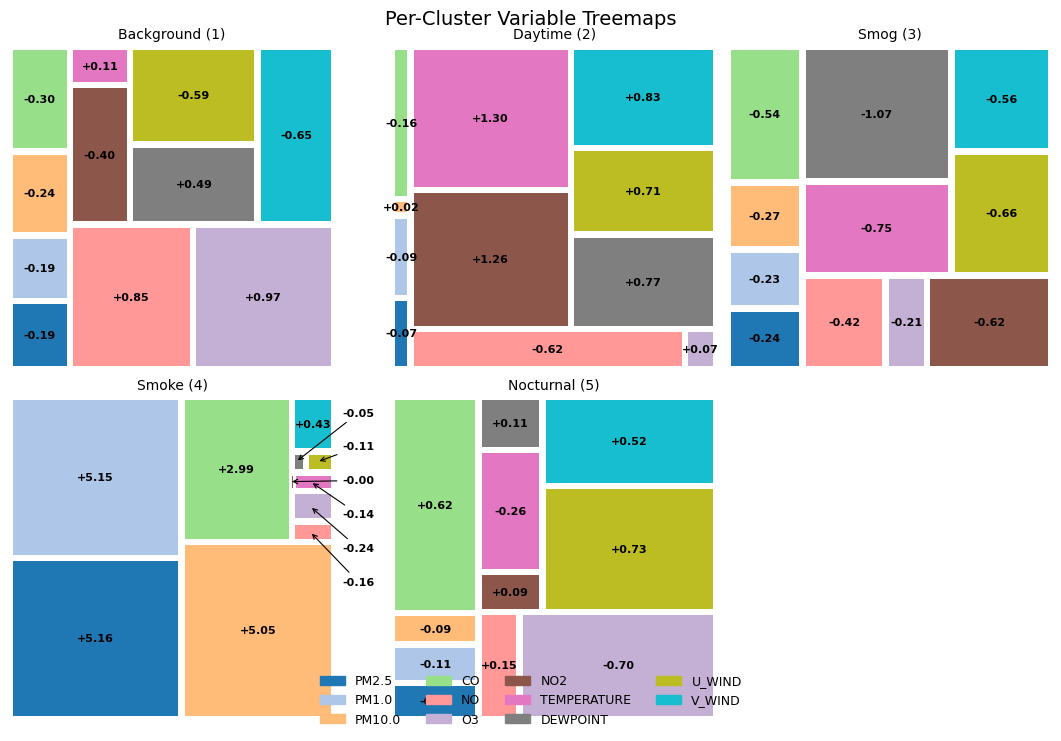

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Patch

def plot_per_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=5, cols=3,
    small_area_threshold=150.0,
    arrow_x_offset=2.5,
    arrow_y_offset=-5,        # <— new parameter
):
    """
    km              : fitted KMeans model
    variables       : list of feature names
    cluster_labels  : dict mapping cluster_id → display name
    small_area_threshold : area below which labels get pulled out
    arrow_x_offset  : how far to the right to place the small‐label column
    """
    # 1) Prepare colors & force one squarify layout so patch order is consistent
    cmap    = plt.get_cmap('tab20')
    palette = [cmap(i/len(variables)) for i in range(len(variables))]
    var_colors = dict(zip(variables, palette))
    _ = squarify.squarify([1]*len(variables), 0,0,100,100)

    # 2) Set up figure/grid
    rows = int(np.ceil(n_clusters/cols))
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*3.5, rows*3.5),
                             constrained_layout=True)
    axes = axes.flatten()

    # 3) Draw each cluster treemap & center‐place *all* labels
    #    We'll also collect the tiny Cluster-4 Text objects for later adjustment.
    texts4 = []
    for cid, ax in enumerate(axes[:n_clusters], start=1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        sizes  = sizes/sizes.sum()*100

        squarify.plot(sizes=sizes,
                      label=None,
                      color=[var_colors[v] for v in variables],
                      ax=ax, pad=True)
        ax.set_title(cluster_labels[cid], fontsize=10, pad=6)
        ax.axis('off')

        # place every text at the exact center
        for patch, var in zip(ax.patches, variables):
            val = center[variables.index(var)]
            txt = f"{val:+.2f}"
            cx  = patch.get_x() + patch.get_width()/2
            cy  = patch.get_y() + patch.get_height()/2

            t = ax.text(cx, cy, txt,
                        ha='center', va='center',
                        fontsize=8, weight='bold',
                        color='black')
            if cid == 4:
                # only care about the small ones; we'll filter by area below
                texts4.append((patch, t))
    # 4) pull out Cluster-4 labels and stack them
    ax4   = axes[3]
    xlim  = ax4.get_xlim()
    ylim  = ax4.get_ylim()
    x_text = xlim[1] + arrow_x_offset

    # filter & sort by patch center-y
    small_labels = sorted(
        [(p, t) for (p,t) in texts4
         if p.get_width()*p.get_height() < small_area_threshold],
        key=lambda pt: pt[0].get_y() + pt[0].get_height()/2,
        reverse=True
    )

    n = len(small_labels)
    if n:
        # shrink the endpoints a bit to avoid clipping
        y_min, y_max = ylim
        y_margin = (y_max - y_min)*0.05
        y_positions = np.linspace(
            y_max - y_margin + arrow_y_offset -2.5,
            y_min + y_margin   + arrow_y_offset +35,
            n
        )

        for (patch, text), y_text in zip(small_labels, y_positions):
            cx = patch.get_x() + patch.get_width()/2
            cy = patch.get_y() + patch.get_height()/2
            val= text.get_text()

            ax4.annotate(
                val,
                xy=(cx-1, cy),
                xytext=(x_text, y_text),
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
                ha='left', va='center',
                fontsize=8, weight='bold'
            )
            text.set_visible(False)

    # 5) Turn off any leftover axes
    for ax in axes[n_clusters:]:
        ax.axis('off')

    # 6) Single legend for all clusters
    handles = [Patch(color=var_colors[v], label=v.upper())
               for v in variables]
    fig.legend(handles=handles, ncol=4,
               loc='lower center', bbox_to_anchor=(0.5,-0.02),
               frameon=False, fontsize=9)

    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=14, y=1.02)
    plt.show()

variables = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2',
             'temperature','dewpoint','u_wind','v_wind']

cluster_labels = {
    1: "Background (1)",
    2: "Daytime (2)",
    3: "Smog (3)",
    4: "Smoke (4)",
    5: "Nocturnal (5)",
}

plot_per_cluster_treemaps(
    km, variables, cluster_labels,
    n_clusters=5, cols=3,
    small_area_threshold=150.0,
    arrow_x_offset=2.5,
    arrow_y_offset= 2.5)


#### Overall Treemap (BSS)

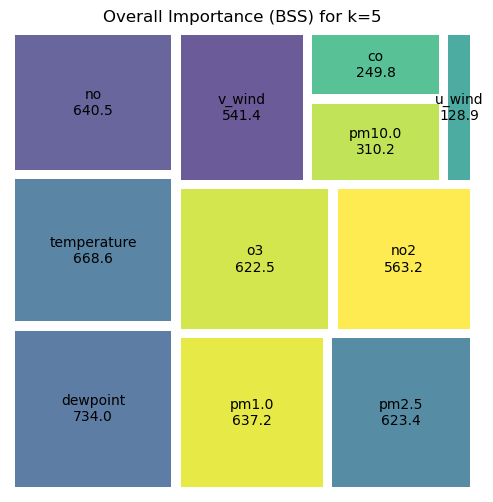

In [23]:
sizes  = imp.values
labels = [f"{v}\n{imp[v]:.1f}" for v in imp.index]

plt.figure(figsize=(6,6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, pad=True)
plt.title(f'Overall Importance (BSS) for k={n}')
plt.axis('off')
plt.show()

#### Export Cluster Dates

In [27]:
export_cluster_dates(df, cluster_id=nid, filename=f'cluster{nid}_dates.txt')

Saved 95 timestamps to cluster4_dates.txt


#### Cluster 4 experimentation

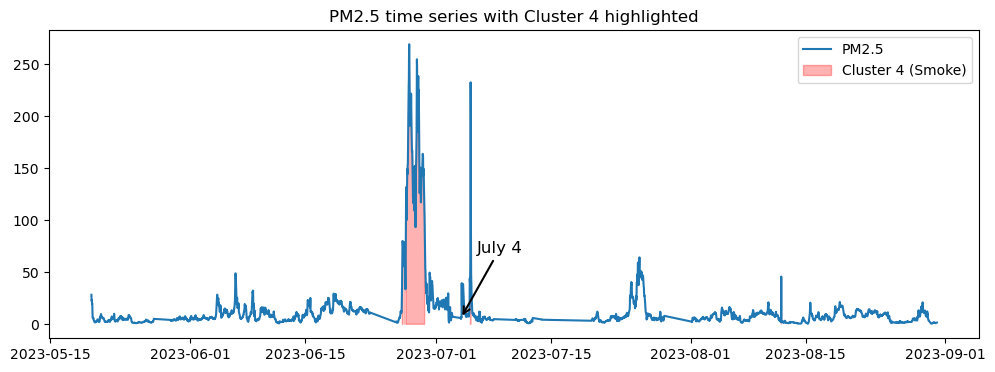

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['pm2.5'], label='PM2.5')
mask4 = df['cluster']==4
plt.fill_between(df.index, df['pm2.5'], where=mask4,
                 color='red', alpha=0.3, label='Cluster 4 (Smoke)')
# annotate July 4
july4 = pd.Timestamp('2023-07-04')
# pick the PM2.5 value at or just before midnight on July 4
pm25_july4 = df['pm2.5'].asof(july4)

plt.annotate(
    'July 4',
    xy=(july4, pm25_july4),
    xytext=(july4 + pd.Timedelta(days=2), pm25_july4 + 60),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=12,
    va='bottom'
)
plt.legend(); plt.title('PM2.5 time series with Cluster 4 highlighted')
plt.show()

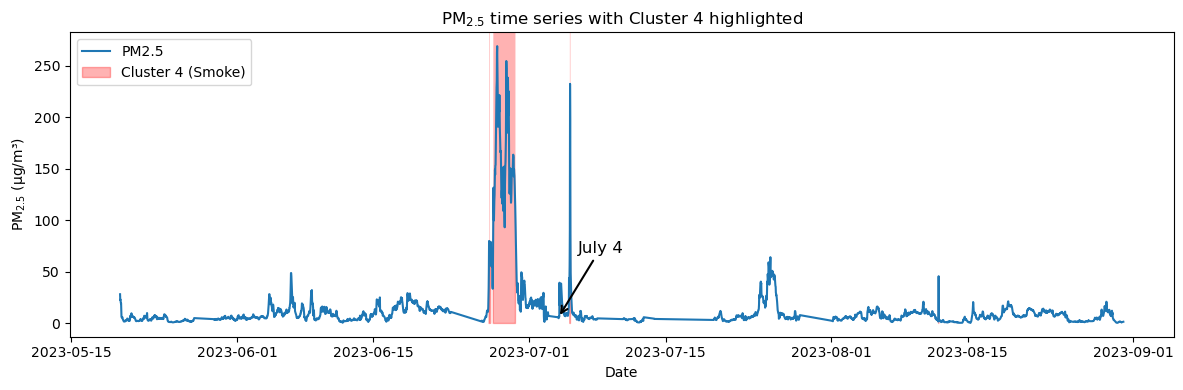

In [15]:
plt.figure(figsize=(12, 4))

# 1) plot PM2.5 on top
plt.plot(df.index, df['pm2.5'], label='PM2.5', linewidth=1.5, zorder=2)

# 2) find where cluster==4
mask4 = (df['cluster'] == 4)

# 3) capture the current y‐limits so we can restore them
ymin, ymax = plt.ylim()

# 4) fill above the curve wherever cluster4 is True
plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask4,
    facecolor='red',
    alpha=0.3,
    interpolate=True
)

plt.fill_between(df.index, df['pm2.5'], where=mask4,
                 color='red', alpha=0.3, label='Cluster 4 (Smoke)', interpolate=True)

# restore y‐limits unchanged
plt.ylim(ymin, ymax)

# 5) annotate “July 4” with an arrow
july4 = pd.Timestamp('2023-07-04')
pm4   = df['pm2.5'].asof(july4)
plt.annotate(
    'July 4',
    xy=(july4, pm4),
    xytext=(july4 + pd.Timedelta(days=2), pm4 + 60),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=12,
    va='bottom'
)

plt.legend(loc='upper left')
plt.title('PM$_{2.5}$ time series with Cluster 4 highlighted')
plt.xlabel('Date')
plt.ylabel('PM$_{2.5}$ (µg/m³)')
plt.tight_layout()
plt.savefig('D://Figures//crocus_2023_NEIU_PM2.5.png')
plt.show()

#### Clusters 2 and 5 experimentation

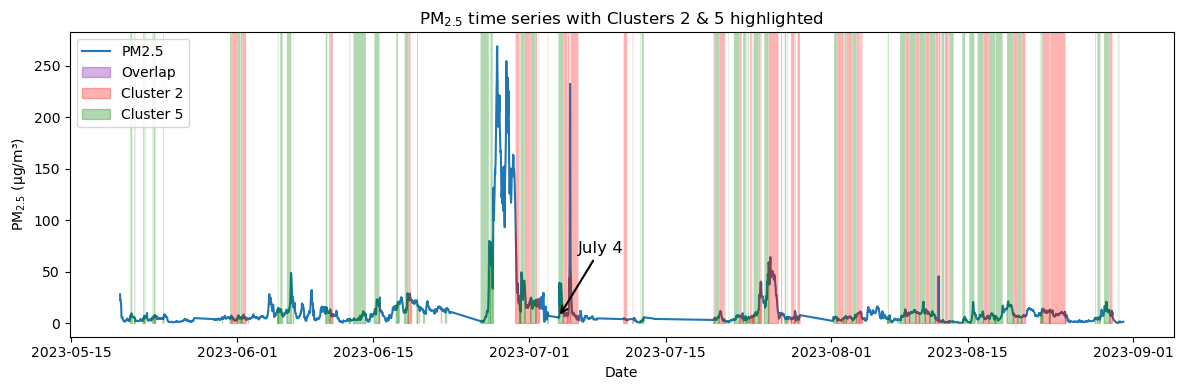

In [18]:
plt.figure(figsize=(12, 4))

# 1) plot PM2.5 on top
plt.plot(df.index, df['pm2.5'], label='PM2.5', linewidth=1.5, zorder=2)

# 2) find where cluster==4
mask2 = (df['cluster'] == 2)
mask5 = (df['cluster'] == 5)
mask_overlap = ((df['cluster']==2) & (df['cluster'] == 5))

mask2_only = mask2 & ~mask_overlap
mask5_only = mask5 & ~mask_overlap

# 3) capture the current y‐limits so we can restore them
ymin, ymax = plt.ylim()

# 4) fill above the curve wherever cluster4 is True
# plt.fill_between(
#     df.index, df['pm2.5'], ymax,
#     where=mask_overlap,
#     facecolor='purple',
#     alpha=0.3,
#     zorder = 4
# )

plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask2_only,
    facecolor='red',
    alpha=0.3,
    zorder = 2
)

plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask5_only,
    facecolor='green',
    alpha=0.3,
    zorder = 3
)
plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask_overlap,
    facecolor='#7200a3',
    alpha=0.3,
    zorder = 6
)

# 5) fill below the curve
plt.fill_between(df.index, df['pm2.5'], where=mask_overlap,
                 color='#7200a3', alpha=0.3, label='Overlap', zorder = 4)

plt.fill_between(df.index, df['pm2.5'], where=mask2_only,
                 color='red', alpha=0.3, label='Cluster 2', zorder = 2)

plt.fill_between(df.index, df['pm2.5'], where=mask5_only,
                 color='green', alpha=0.3, label='Cluster 5', zorder = 3)

# plt.fill_between(df.index, df['pm2.5'], where=mask_overlap,
#                  color='purple', alpha=1, label='Overlap', zorder = 1)

# restore y‐limits unchanged
plt.ylim(ymin, ymax)

# 6) annotate “July 4” with an arrow
july4 = pd.Timestamp('2023-07-04')
pm4   = df['pm2.5'].asof(july4)
plt.annotate(
    'July 4',
    xy=(july4, pm4),
    xytext=(july4 + pd.Timedelta(days=2), pm4 + 60),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=12,
    va='bottom'
)

plt.legend(loc='upper left')
plt.title('PM$_{2.5}$ time series with Clusters 2 & 5 highlighted')
plt.xlabel('Date')
plt.ylabel('PM$_{2.5}$ (µg/m³)')
plt.tight_layout()
plt.show()

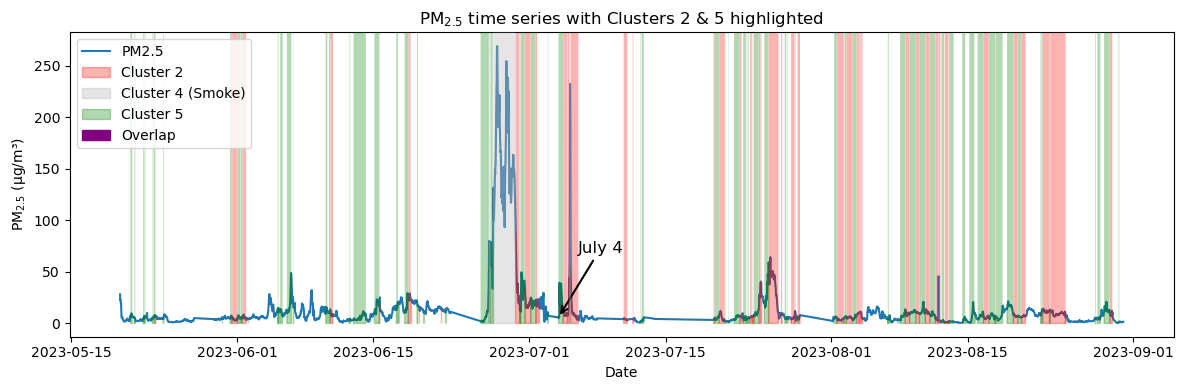

In [25]:
plt.figure(figsize=(12, 4))

# 1) plot PM2.5 on top
plt.plot(df.index, df['pm2.5'], label='PM2.5', linewidth=1.5, zorder=2)

# 2) find where cluster==4
mask1 = (df['cluster'] == 1)
mask2 = (df['cluster'] == 2)
mask3 = (df['cluster'] == 3)
mask4 = (df['cluster'] == 4)
mask5 = (df['cluster'] == 5)
mask_overlap = ((df['cluster']==2) & (df['cluster'] == 5))

mask2_only = mask2 & ~mask_overlap
mask5_only = mask5 & ~mask_overlap

# 3) capture the current y‐limits so we can restore them
ymin, ymax = plt.ylim()

# 4) fill above the curve wherever cluster4 is True

plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask2,
    facecolor='red',
    alpha=0.3,
    zorder = 2
)

plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask4,
    facecolor='darkgray',
    alpha=0.3,
    zorder = 4
)

plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask5,
    facecolor='green',
    alpha=0.3,
    zorder = 3
)
plt.fill_between(
    df.index, df['pm2.5'], ymax,
    where=mask_overlap,
    facecolor='#7200a3',
    alpha=0.3,
    zorder = 0
)

# 5) fill below the curve
# plt.fill_between(df.index, df['pm2.5'], where=mask_overlap,
#                  color='#7200a3', alpha=0.3, label='Overlap', zorder = 4)

plt.fill_between(df.index, df['pm2.5'], where=mask2,
                 color='red', alpha=0.3, label='Cluster 2', zorder = 2)

plt.fill_between(df.index, df['pm2.5'], where=mask4,
                 color='darkgray', alpha=0.3, label='Cluster 4 (Smoke)', zorder = 4)

plt.fill_between(df.index, df['pm2.5'], where=mask5,
                 color='green', alpha=0.3, label='Cluster 5', zorder = 3)

plt.fill_between(df.index, df['pm2.5'], where=mask_overlap,
                 color='purple', alpha=1, label='Overlap', zorder = 0)


# restore y‐limits unchanged
plt.ylim(ymin, ymax)

# 6) annotate “July 4” with an arrow
july4 = pd.Timestamp('2023-07-04')
pm4   = df['pm2.5'].asof(july4)
plt.annotate(
    'July 4',
    xy=(july4, pm4),
    xytext=(july4 + pd.Timedelta(days=2), pm4 + 60),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=12,
    va='bottom'
)

plt.legend(loc='upper left')
plt.title('PM$_{2.5}$ time series with Clusters 2 & 5 highlighted')
plt.xlabel('Date')
plt.ylabel('PM$_{2.5}$ (µg/m³)')
plt.tight_layout()
plt.show()

#### Clusters Vs Time

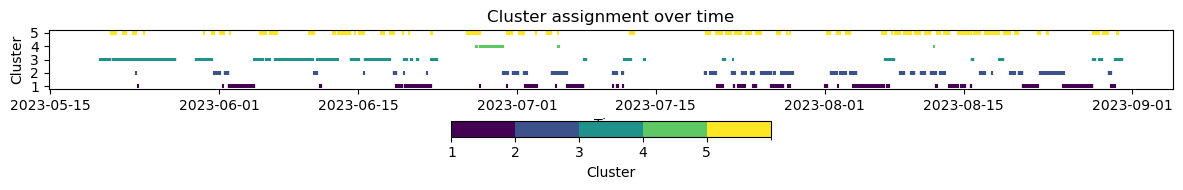

In [76]:
plot_cluster_timeline(df, n_clusters=n)

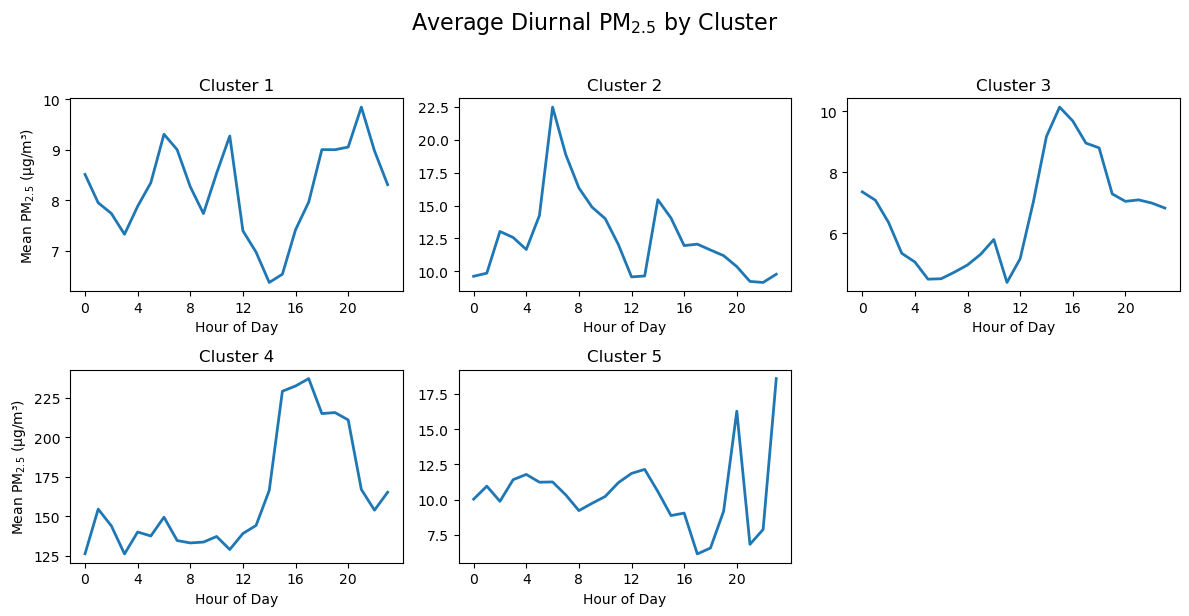

In [78]:
cluster_through_time(df)

#### Cluster 4 versus background

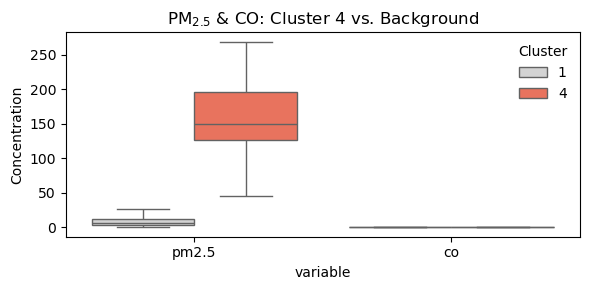

In [30]:
plt.figure(figsize=(6,3))
# melt only PM2.5 and CO for brevity
m = df[['cluster','pm2.5','co']].query('cluster in [1,4]').melt(
    id_vars='cluster',
    var_name='variable',
    value_name='value'
)
sns.boxplot(x='variable', y='value', hue='cluster', data=m,
            palette={1:'lightgray',4:'tomato'}, fliersize=0)
plt.ylabel('Concentration')
plt.title('PM$_{2.5}$ & CO: Cluster 4 vs. Background')
plt.legend(title='Cluster', loc='upper right', frameon=False)
plt.tight_layout()


C:\Users\video\AppData\Local\Temp\ipykernel_62828\1261578104.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\video\AppData\Local\Temp\ipykernel_62828\1261578104.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


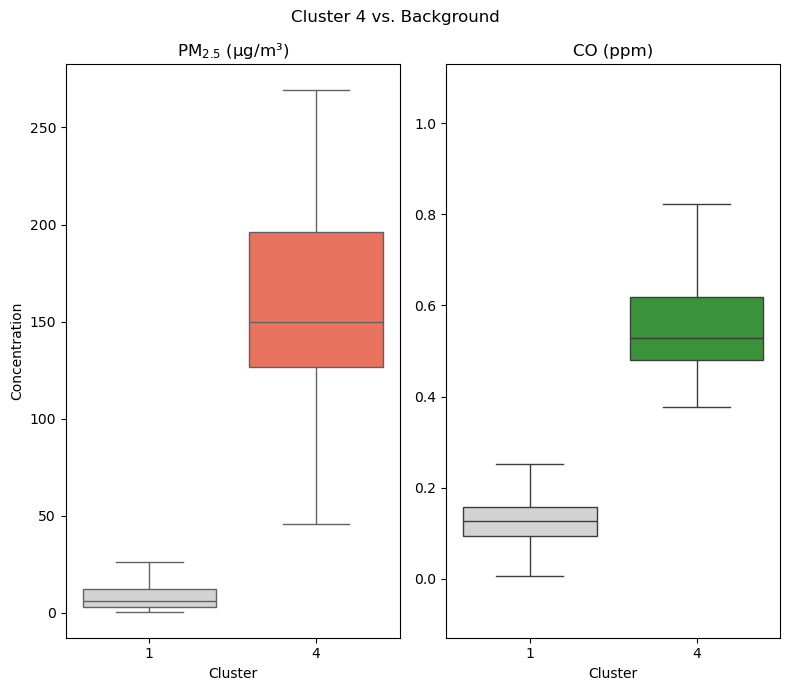

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8,7), sharey=False)

# PM2.5 panel
sns.boxplot(
    x='cluster', y='pm2.5',
    data=df[df.cluster.isin([1,4])],
    order=[1,4],
    palette=['lightgray','tomato'],
    fliersize=0,
    ax=axes[0]
)
axes[0].set_title('PM$_{2.5}$ (µg/m³)')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Concentration')

# CO panel
sns.boxplot(
    x='cluster', y='co',
    data=df[df.cluster.isin([1,4])],
    order=[1,4],
    palette=['lightgray','tab:green'],
    fliersize=0,
    ax=axes[1]
)
axes[1].set_title('CO (ppm)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('')

fig.suptitle('Cluster 4 vs. Background')
plt.tight_layout(rect=[0,0,1,1])
plt.savefig('output.png')
plt.show()

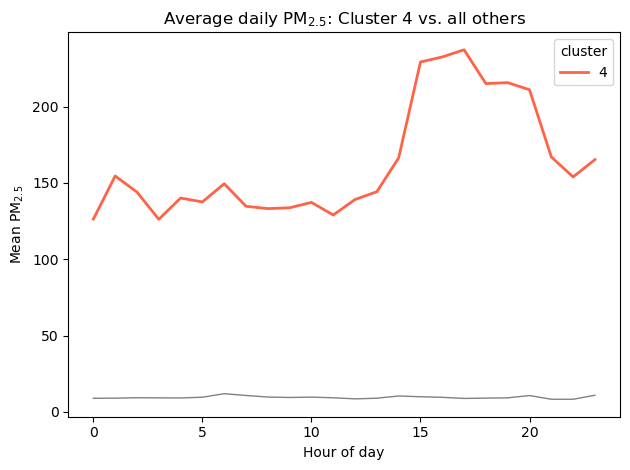

In [39]:
hourly = df.groupby(['hour','cluster'])['pm2.5'].mean().unstack()
hourly[[4]].plot(kind='line', lw=2, color='tomato', legend=True)
hourly.drop(columns=4).mean(axis=1).plot(lw=1, color='gray')
plt.xlabel('Hour of day')
plt.ylabel('Mean PM$_{2.5}$')
plt.title('Average daily PM$_{2.5}$: Cluster 4 vs. all others')
plt.tight_layout()


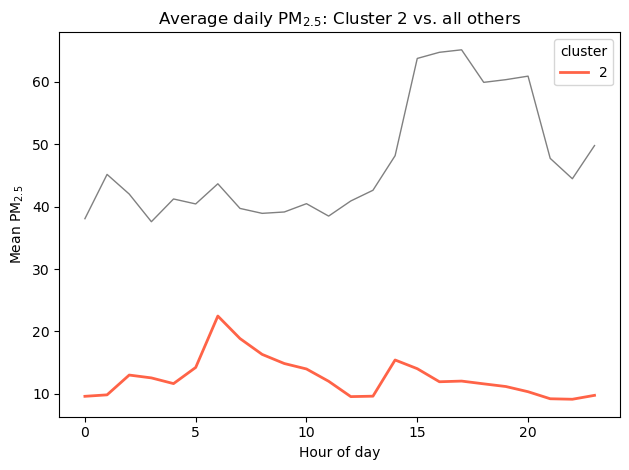

In [45]:
hourly = df.groupby(['hour','cluster'])['pm2.5'].mean().unstack()
hourly[[2]].plot(kind='line', lw=2, color='tomato', legend=True)
hourly.drop(columns=2).mean(axis=1).plot(lw=1, color='gray')
plt.xlabel('Hour of day')
plt.ylabel('Mean PM$_{2.5}$')
plt.title('Average daily PM$_{2.5}$: Cluster 2 vs. all others')
plt.tight_layout()


#### Export netCDF

In [3]:
ds_out = df.to_xarray()
# vars_list_exp = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2','temperature','dewpoint','u_wind','v_wind']
time_frame_for_exp = 30 # change this for the dataset that is being exported

In [4]:
output_dir = "C://Users//video//Documents//My Project//summer2025//Brandon_Swanson"

new_file_name = f"crocus_neiu_merged_{time_frame_for_exp}min.nc"
output_file_path = os.path.join(output_dir, new_file_name)

# Save the resampled data to a new netCDF file
ds_out.to_netcdf(output_file_path)
print(f"Resampled data saved to {output_file_path}")

Resampled data saved to C://Users//video//Documents//My Project//summer2025//Brandon_Swanson\crocus_neiu_merged_30min.nc


In [5]:
test = xr.open_dataset("C://Users//video//Documents//My Project//summer2025//Brandon_Swanson//crocus_neiu_merged_30min.nc", engine='netcdf4')
test

<xarray.Dataset> Size: 416kB
Dimensions:      (index: 4000)
Coordinates:
  * index        (index) int64 32kB 0 1 2 3 4 5 ... 3995 3996 3997 3998 3999
Data variables:
    pm2.5        (index) float64 32kB ...
    pm1.0        (index) float64 32kB ...
    pm10.0       (index) float64 32kB ...
    co           (index) float64 32kB ...
    no           (index) float64 32kB ...
    o3           (index) float64 32kB ...
    no2          (index) float64 32kB ...
    temperature  (index) float64 32kB ...
    dewpoint     (index) float64 32kB ...
    u_wind       (index) float64 32kB ...
    v_wind       (index) float64 32kB ...
    time         (index) datetime64[ns] 32kB ...

In [15]:
testnew = test.to_pandas
testnew().head(10)

pm2.5      pm1.0     pm10.0        co        no        o3  \
index                                                                  
0      28.350000  24.050000  35.450000  0.218233  0.012033  0.027467   
1      22.733333  19.316667  28.150000  0.179633  0.012567  0.022667   
2      23.266667  19.966667  28.416667  0.173333  0.013800  0.020900   
3      20.916667  17.783333  25.566667  0.179433  0.016300  0.022067   
4      19.633333  16.633333  23.583333  0.185333  0.017000  0.022133   
5      19.766667  17.050000  24.183333  0.183633  0.017033  0.014800   
6      12.483333  10.800000  15.716667  0.151800  0.016567  0.010233   
7       6.500000   5.566667  10.016667  0.114400  0.016900  0.008167   
8       5.966667   5.150000   9.050000  0.095667  0.017167  0.006633   
9       5.800000   5.033333   8.483333  0.083400  0.017167  0.006633   

            no2  temperature  dewpoint    u_wind    v_wind                time  
index                                                                           
0      0.013567    15.220000  7.995897 -1.607238 -1.670666 2023-05-20 00:00:00  
1      0.009133    14.220000  6.396147 -1.808306 -1.944357 2023-05-20 00:30:00  
2      0.010767    13.826667  6.456700 -2.156636 -1.122327 2023-05-20 01:00:00  
3      0.010200    13.553333  6.554624 -1.531059  0.653497 2023-05-20 01:30:00  
4      0.008800    13.440000  6.589255 -0.022842  1.309572 2023-05-20 02:00:00  
5      0.010433    13.460000  6.446772  0.082459  1.277045 2023-05-20 02:30:00  
6      0.008633    13.570000  5.430516  1.347791  0.207419 2023-05-20 03:00:00  
7      0.006300    13.543333  4.768541  1.027464  0.835463 2023-05-20 03:30:00  
8      0.005833    13.243333  4.581238  1.207284  0.447844 2023-05-20 04:00:00  
9      0.006000    12.870000  4.403312  1.402607  0.295080 2023-05-20 04:30:00